In [1]:
# Autosave each 30s
%autosave 30

import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
import os
import timeit
import copy
import gc
import math
import time
import scipy

from scipy import stats
from scipy.special import erfc
from scipy.signal import fftconvolve
from itertools import product, chain, combinations
from collections import defaultdict, Counter, OrderedDict
from tqdm import tqdm

#sklearn
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#skimage
import skimage
from skimage import io, transform, color
from skimage.transform import resize

#IPython imports
from IPython.display import Image, display, clear_output
from IPython.core.display import HTML
from IPython.display import FileLink, FileLinks

#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 1
# Below comes the list of modules which is automatically reimported
# %aimport cs231n.classifiers.k_nearest_neighbor

_add_to_path = True

Autosaving every 30 seconds


ImportError: Traceback (most recent call last):
  File "/home/alexander/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/alexander/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/alexander/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/alexander/anaconda3/envs/tensorflow/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/alexander/anaconda3/envs/tensorflow/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcudnn.so.6: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
class A:
    def __init__(self, x):
        self.x = x
    def __bool__(self):
        return self.x > 5
    
a1 = A(1)
a2 = A(5)
if a1:
    print(a1.x)
if a2:
    print(a2.x)

In [2]:
import sys
if _add_to_path:
    sys.path.append('../../../')
    _add_to_path = False
CIFAR10_DIR = '../../../datasets/CIFAR10'

from ml.utils import get_CIFAR10_data, load_CIFAR10
from ml.generators import BatchGenerator
from ml.utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ml.neural_network.cs231n.second.layers import *
from ml.neural_network.cs231n.second.optimizers import *
from ml.neural_network.cs231n.second.solver import Solver
from ml.neural_network.cs231n.second.fcn import FullyConnectedNet
from ml.neural_network.cs231n.second.two_layer_net import TwoLayerNet

from ml.neural_network.cs231n.second.conv_layers import *
from ml.neural_network.cs231n.second.conv_layers_fast import *

#from ml.linear_model import svm_loss_naive, svm_loss_vectorized, softmax_loss_naive, softmax_loss_vectorized
#from ml.neural_network import Sequential, NetworkTrainer
#from ml.neural_network.layers import Dense, Dropout, SoftMax
#from ml.neural_network.nonlinearities import ReLU, LeakyReLU, ELU, SoftPlus
#from ml.neural_network.criterions import MulticlassLogLoss

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

<a id='toc'></a>
# Table of Contents
* [1. Fully-Connected Neural Nets](#fcn)
    * [1.1 Affine layer](#fcn_affine)
        * [1.1.1 Affine layer: foward](#fcn_affine_forw)
        * [1.1.2 Affine layer: backward](#fcn_affine_forw)
    * [1.2 ReLU layer](#fcn_relu)
        * [1.2.1 ReLU layer: foward](#fcn_relu_forw)
        * [1.2.2 ReLU layer: backward](#fcn_relu_forw)
    * [1.3 "Sandwich" layers](#fcn_sand)
    * [1.4 Loss layers: Softmax and SVM](#fcn_loss)
    * [1.5 BatchNormalization](#batch_norm)
        * [1.5.1 Batch normalization: forward](#batch_norm_forw)
        * [1.5.2 Batch normalization: backward](#batch_norm_back)
        * [1.5.3 Batch Normalization: alternative backward (OPTIONAL, +3 points extra credit)](#batch_norm_opt)
    * [1.6 Dropout](#dropout)
        * [1.6.1 Dropout forward pass](#dropout_forward)
        * [1.6.2 Dropout backward pass](#dropout_backward)
    * [1.7 Two-layer network](#fcn_twolayer)
    * [1.8 Solver](#fcn_solver)
    * [1.9 Update rules](#fcn_updates)
        * [1.9.1 SGD + Momentum](#fcn_updates_momentum)
        * [1.9.2 RMSProp and Adam](#fcn_updates_rmsprop)
        * [1.9.3 Comparison of update rules](#update_comp)
    * [1.10 Multilayer network](#fcn_mult)
        * [1.10.1 Loading data](#fcn_load)
        * [1.10.2 Initial loss and gradient check](#fcn_check)
        * [1.10.3 Batch normalization](#bn_mult)
            * [1.10.3.1 Test](#bn_test)
            * [1.10.3.2 Batch normalization for deep networks](#bn_deep)
            * [1.10.3.3 Batch normalization and initialization](#bn_deep_init)
        * [1.10.4 Dropout](#fcn_dropout)
            * [1.10.4.1 Regularization experiment](#reg_exp)
        * [1.10.5 Final model](#fcn_final)
            * [1.10.5.1 Train model](#fcn_final_train)
            * [1.10.5.2 Test model](#fcn_final_test)

* [2. Convolutional Networks](#cnn)
    * [2.1 Convolution](#cnn_conv)
        * [2.1.1 Convolution: Naive forward pass](#cnn_conv_forw)
        * [2.1.2 Aside: Image processing via convolutions](#cnn_conv_aside)
        * [2.1.3 Convolution: Naive backward pass](#cnn_conv_back)
    * [2.2 Max pooling](#max_pooling)
        * [2.2.1 Max pooling: Naive forward](#cnn_max_pooling_forw)
        * [2.2.2 Max pooling: Naive backward](#cnn_max_pooling_back)
    * [2.3 Fast layers](#cnn_fast)
    * [2.4 Convolutional "sandwich" layers](#cnn_sand)
    * [2.5 Spatial Batch Normalization](#cnn_spatial)
        * [2.5.1 Spatial batch normalization: forward](#cnn_spatial_forw)
        * [2.5.2 Spatial batch normalization: backward](#cnn_spatial_back)
    * [2.6 Three Layer ConvNet](#cnn_three)
        * [2.6.1 Sanity check loss](#cnn_three_sanity)
        * [2.6.2 Gradient check](#cnn_three_grad)
        * [2.6.3 Overfit small data](#cnn_three_overfit)
        * [2.6.4 Train net](#cnn_three_train)
        * [2.6.5 Visualize filters](#cnn_three_visualize)

* [3. TensorFlow](#tf)
    * [3.1 Introduction](#tf_intro)
    * [3.2 Load dataset](#tf_load)
    * [3.3 Example tensorflow model](#tf_example)
        * [3.3.1 Some useful utilities](#tf_some)
        * [3.3.2 The example model itself](#tf_example)
        * [3.3.3 TensorFlow detail](#tf_detail)
        * [3.3.4 Training the model on one epoch](#tf_training)
    * [3.4 Training a specific model](#tf_specific)
        * [GPU](#tf_gpu)
    * [3.5 Train a _great_ model on CIFAR-10!](#tf_cifar10_great)
        * [Model 1](#tf_model1)
        * [Model 2](#tf_model2)
        * [Extra credit description](#tf_extra)
    * [Tutorial](#tf_tutorial)
        * [Constants](#tf_constants)
        * [Variables](#tf_variables)

## Loading CIFAR10 data [[toc](#toc)]

In [3]:
%%time
gc.collect()
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                        substract_mean=True, random_state=1)

data['X_train'] /= 255.0
data['X_test']  /= 255.0
data['X_val']   /= 255.0

X_train = data['X_train']; y_train = data['y_train']
X_val   = data['X_val'];   y_val   = data['y_val']
X_test  = data['X_test'];  y_test  = data['y_test']
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
CPU times: user 2.31 s, sys: 1.15 s, total: 3.46 s
Wall time: 3.74 s


<a id='fcn'></a>
# 1. Fully-Connected Neural Nets [[toc](#toc)]
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

<a id='fcn_affine'></a>
## 1.1 Affine layer [[toc](#toc)]

<a id='fcn_affine_forw'></a>
### 1.1.1 Affine layer: foward [[toc](#toc)]
Open the file `ml/neural_network/cs231n/second/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [11]:
# Test the affine_forward function
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size  = num_inputs * np.prod(input_shape) # 2 * 120 = 240
weight_size = output_dim * np.prod(input_shape) # 3 * 120 = 360

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape) # [2, 120] -> [2, 4, 5, 6]
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim) # [360] - > [120, 3]
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76985004799e-10


<a id='fcn_affine_back'></a>
### 1.1.2 Affine layer: backward [[toc](#toc)]
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [12]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3); x = x.reshape((10, 6))
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)
print('x.shape =', x.shape)
print('w.shape =', w.shape)
print('b.shape =', b.shape)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
print('dx.shape =', dx.shape)
print('dw.shape =', dw.shape)
print('db.shape =', db.shape)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

x.shape = (10, 6)
w.shape = (6, 5)
b.shape = (5,)
dx.shape = (10, 6)
dw.shape = (6, 5)
db.shape = (5,)
Testing affine_backward function:
dx error:  1.09081995087e-10
dw error:  2.17526355046e-10
db error:  7.73697883449e-12


<a id='fcn_relu'></a>
## 1.2 ReLU layer [[toc](#toc)]

<a id='fcn_relu_forw'></a>
### 1.2.1 ReLU layer: forward [[toc](#toc)]
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [13]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


<a id='fcn_relu_back'></a>
### 1.2.2 ReLU layer: backward [[toc](#toc)]
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [14]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27563491363e-12


<a id='fcn_sand'></a>
## 1.3 "Sandwich" layers [[toc](#toc)]
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `ml/neural_network/cs231n/second/layers.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [18]:
np.random.seed(231)
x = np.random.randn(2, 3, 4); x = x.reshape((x.shape[0], -1))
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.39553504205e-11
dw error:  8.16201110576e-11
db error:  7.82672402146e-12


<a id='fcn_loss'></a>
## 1.4 Loss layers: Softmax and SVM [[toc](#toc)]
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `ml/neural_network/cs231n/second/layers.py`.

You can make sure that the implementations are correct by running the following:

In [19]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.9996027491
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.3025458445
dx error:  9.38467316199e-09


<a id='batch_norm'></a>
# 1.5 Batch Normalization [[toc](#toc)]

One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [3].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

<a id='batch_norm_forw'></a>
### 1.5.1 Batch normalization: Forward  [[toc](#toc)]
In the file `cs231n/layers.py`, implement the batch normalization forward pass in the function `batchnorm_forward`. Once you have done so, run the following to test your implementation.

In [31]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  1.77635684e-17  -5.32907052e-17   2.13717932e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


In [32]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [ 1.01531428  1.01238373  0.97819988]


<a id='batch_norm_back'></a>
### 1.5.2 Batch Normalization: backward  [[toc](#toc)]
Now implement the backward pass for batch normalization in the function `batchnorm_backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Once you have finished, run the following to numerically check your backward pass.

In [33]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 100, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)
h = 1e-6
debug = True

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout, h)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout, h)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout, h)

_, cache = batchnorm_forward(x, gamma, beta, bn_param, debug=debug)
dx, dgamma, dbeta = batchnorm_backward(dout, cache, debug=debug)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.12162375496e-05
dgamma error:  2.85728970908e-10
dbeta error:  3.50041508493e-10


<a id='batch_norm_opt'></a>
### 1.5.3 Batch Normalization: alternative backward (OPTIONAL, +3 points extra credit)  [[toc](#toc)]
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For the sigmoid function, it turns out that you can derive a very simple formula for the backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can also derive a simple expression for the batch normalization backward pass if you work out derivatives on paper and simplify. After doing so, implement the simplified batch normalization backward pass in the function `batchnorm_backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

NOTE: This part of the assignment is entirely optional, but we will reward 3 points of extra credit if you can complete it.

In [38]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()
print(dx1.shape, dgamma1.shape, dbeta1.shape)
print(dx2.shape, dgamma2.shape, dbeta2.shape)

print('dx difference: ',     rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ',  rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

(100, 500) (500,) (500,)
(100, 500) (500,) (500,)
dx difference:  5.84557095839e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.82x


<a id='dropout'></a>
## 1.6 Dropout [[toc](#toc)]
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

<a id='dropout_forward'></a>
### 1.6.1 Dropout forward pass  [[toc](#toc)]
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [4]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10
seed = 0
gen = np.random.RandomState(seed)
for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p, 'gen': gen})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p, 'gen': gen})
    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.0002078785
Mean of train-time output:  7.00311276126
Mean of test-time output:  7.00014551493
Fraction of train-time output set to zero:  0.299804
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078785
Mean of train-time output:  3.98521948532
Mean of test-time output:  4.00008315139
Fraction of train-time output set to zero:  0.60156
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0002078785
Mean of train-time output:  2.52026295957
Mean of test-time output:  2.50005196962
Fraction of train-time output set to zero:  0.748108
Fraction of test-time output set to zero:  0.0



<a id='dropout_backward'></a>
### 1.6.2 Dropout backward pass  [[toc](#toc)]
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [6]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [7]:
np.random.seed(231)
x = np.random.randn(5, 5) + 10
seed = 0
gen = np.random.RandomState(seed)

dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'gen': gen, 'seed': seed}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout, 1e-5)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.89289321191e-11


<a id='fcn_twolayer'></a>
## 1.7 Two-layer network [[toc](#toc)]
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `ml/neaural_network/cs231n/second/two_layer_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [8]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7

X = np.random.randn(N, D)        # [3, 5]
y = np.random.randint(C, size=N) # [3,]

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right: W1_std = {}, std = {}'.format(W1_std, std)
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right: W2_std = {}, std = {}'.format(W2_std, std)
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.17e-10
b1 relative error: 6.19e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 1.37e-07
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


<a id='fcn_solver'></a>
## 1.8 Solver [[toc](#toc)]
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `ml/neural_network/cs231n/second/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [13]:
input_dim = np.prod(X_train.shape[1:])
hidden_dim = 200
num_classes = 10
data = {'X_train': X_train, 'y_train': y_train,
        'X_val':   X_val,   'y_val': y_val}
model = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=1e-5, random_state=123)
optim_config = {'learning_rate': 1e-2}
solver = Solver(model, data, update_rule='sgd', optim_config=optim_config, lr_decay=0.985,
                num_epochs=100, batch_size=200, 
                verbose=True, print_every_epoch=1, seed=111)
solver.train()

num of epochs = 100
num of iterations = 24500
iterations per epoch = 245
(Epoch 1/100) train acc: 0.32; val acc: 0.31, train loss: 1.9855; val loss: 1.9882
(Epoch 2/100) train acc: 0.36; val acc: 0.34, train loss: 1.8771; val loss: 1.8901
(Epoch 3/100) train acc: 0.37; val acc: 0.36, train loss: 1.8134; val loss: 1.837
(Epoch 4/100) train acc: 0.39; val acc: 0.37, train loss: 1.7696; val loss: 1.7978
(Epoch 5/100) train acc: 0.4; val acc: 0.38, train loss: 1.7348; val loss: 1.7694
(Epoch 6/100) train acc: 0.41; val acc: 0.39, train loss: 1.7073; val loss: 1.7438
(Epoch 7/100) train acc: 0.42; val acc: 0.39, train loss: 1.6835; val loss: 1.7232
(Epoch 8/100) train acc: 0.42; val acc: 0.39, train loss: 1.6636; val loss: 1.7052
(Epoch 9/100) train acc: 0.43; val acc: 0.4, train loss: 1.6461; val loss: 1.6871
(Epoch 10/100) train acc: 0.44; val acc: 0.41, train loss: 1.6301; val loss: 1.6743
(Epoch 11/100) train acc: 0.44; val acc: 0.41, train loss: 1.6157; val loss: 1.6624
(Epoch 12/100) 

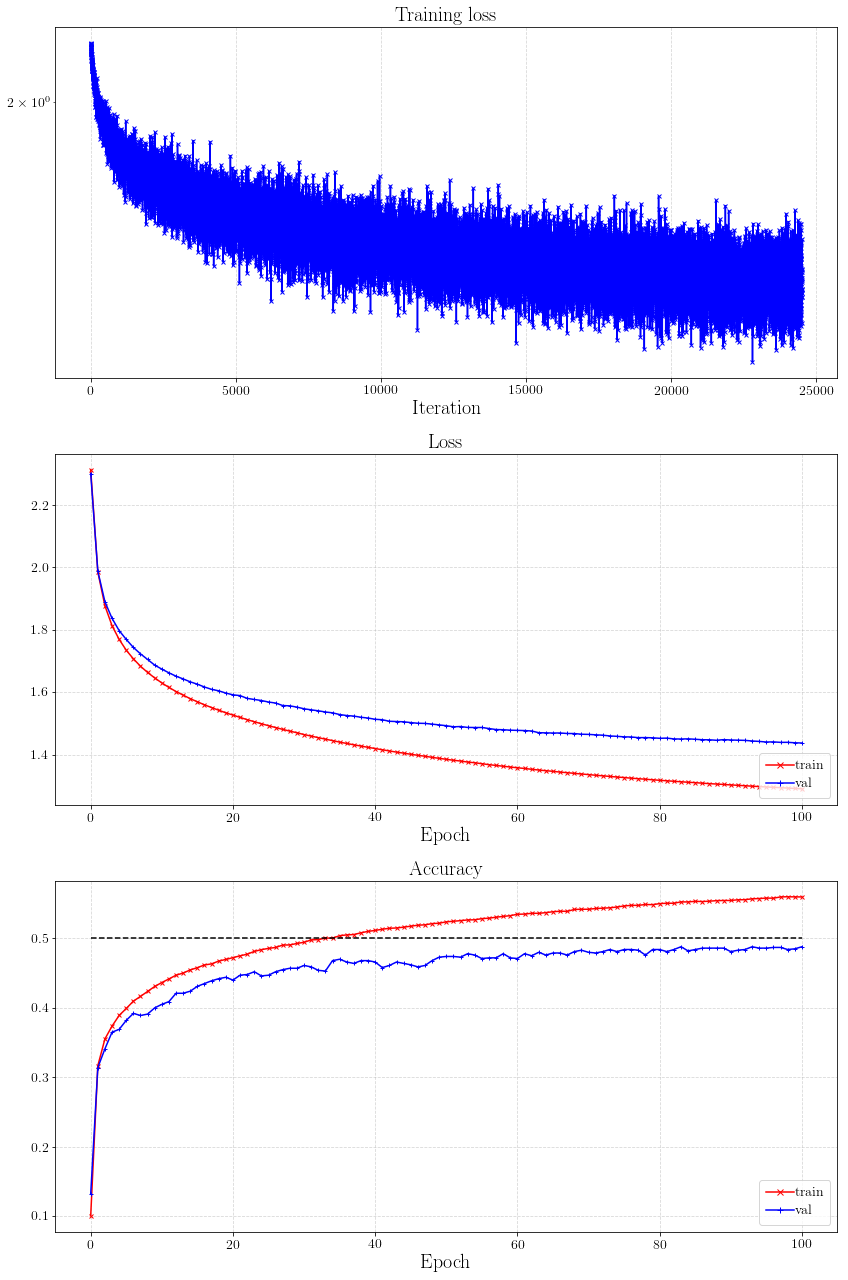

In [17]:
# Run this cell to visualize training loss and train / val accuracy
loss_history = np.array(solver.loss_history)
train_loss_history = np.array(solver.train_loss_history)
train_acc_history  = np.array(solver.train_acc_history)
val_loss_history   = np.array(solver.val_loss_history)
val_acc_history    = np.array(solver.val_acc_history)

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.yscale('log')
plt.plot(loss_history, marker='x', color='b', ms=4)
plt.xlabel('Iteration')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(3, 1, 2)
plt.title('Loss')
plt.plot(train_loss_history, '-x', color='r', ms=4, label='train')
plt.plot(val_loss_history, '-+', color='b', ms=4, label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(3, 1, 3)
plt.title('Accuracy')
plt.plot(train_acc_history, '-x', color='r', ms=4, label='train')
plt.plot(val_acc_history, '-+', color='b', ms=4, label='val')
plt.plot([0.5] * len(val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.5)
plt.gcf().set_size_inches(12, 18)
plt.tight_layout()
plt.show()

<a id='fcn_updates'></a>
## 1.9 Update rules [[toc](#toc)]
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

<a id='fcn_updates_momentum'></a>
### 1.9.1 SGD + Momentum [[toc](#toc)]
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [4]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


<a id='fcn_updates_rmsprop'></a>
### 1.9.2 RMSProp and Adam [[toc](#toc)]
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [25]:
# Test RMSProp implementation; you should see errors less than 1e-7

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [28]:
# Test Adam implementation; you should see errors around 1e-7 or less

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

<a id='update_comp'></a>
### 1.9.3 Comparison of update rules [[toc](#toc)]

In [20]:
recalculate = False # If true, all update rules are run again
calculated_ = False  
if os.path.isfile('solver_results.pkl'):
    SOLVER_RESULTS = pkl.load(open('solver_results.pkl', 'rb'))
    calculated_ = True
    print('Already calculated')
else:
    SOLVER_RESULTS = {}

Already calculated


In [21]:
num_train = 10000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


optim_configs = {'sgd':          {'learning_rate': 1e-2},
                 'sgd_momentum': {'learning_rate': 1e-2, 'momentum': 0.5},
                 'rmsprop':      {'learning_rate': 1e-2, 'decay_rate': 0.99},
                 'adam':         {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999}}
# Setting common parameters
for config in optim_configs.values():
    config['learning_rate_decay'] = 0.98

if (not calculated_) or recalculate:
    print('Starting calculations:')
    for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
        print('running with', update_rule)
        model = FullyConnectedNet([100, 100], weight_scale=None, use_batchnorm=False, dropout=0)
        solver = Solver(model, small_data,
                        num_epochs=50, 
                        batch_size=100,
                        update_rule=update_rule,
                        optim_config=optim_configs[update_rule],
                        verbose=True,
                        print_every_epoch=1)
        solver.train()
        SOLVER_RESULTS[update_rule] = solver.history
        print()
    pkl.dump(SOLVER_RESULTS, open('solver_results.pkl', 'wb'))
else:
    print('Already calculated')

Already calculated


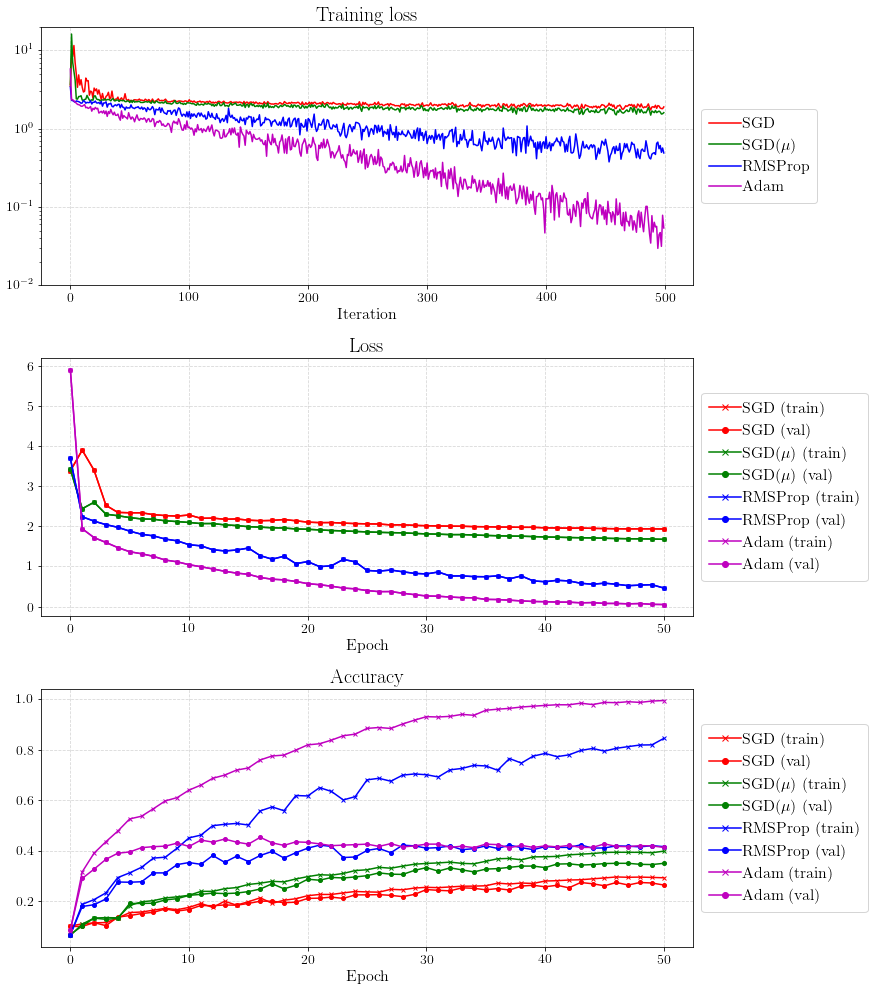

In [22]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
titles  = ['Training loss', 'Loss', 'Accuracy']
xlabels = ['Iteration', 'Epoch', 'Epoch']

for i in range(3):
    ax = axarr[i]
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(xlabels[i], fontsize=16)
    
rule_map = {'sgd': r'SGD', 'sgd_momentum': r'SGD($\mu$)', 'rmsprop': 'RMSProp', 'adam': 'Adam'}
colors = ['r', 'b']

markers = {'train': 'x', 'val': 'o'}
colors  = {'sgd': 'r', 'sgd_momentum': 'g', 'rmsprop': 'b', 'adam': 'm'}

for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
    ax = axarr[0]
    loss_history = SOLVER_RESULTS[update_rule]['loss_history']
    ax.plot(loss_history[::10], '-', color=colors[update_rule], ms=2, label=rule_map[update_rule])
    ax.set_yscale('log')
    ax.set_ylim([1e-2, 20])
    
    ax = axarr[1]
    train_loss_history = SOLVER_RESULTS[update_rule]['train_loss_history']
    ax.plot(train_loss_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_loss_history = SOLVER_RESULTS[update_rule]['train_loss_history']
    ax.plot(val_loss_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')
    
    ax = axarr[2]
    train_acc_history = SOLVER_RESULTS[update_rule]['train_acc_history']
    ax.plot(train_acc_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_acc_history = SOLVER_RESULTS[update_rule]['val_acc_history']
    ax.plot(val_acc_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')

for i in range(3):
    axarr[i].legend(loc='center left', ncol=1, fontsize=16, bbox_to_anchor=(1.0, 0.5))
    axarr[i].grid(linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()

<a id='fcn_mult'></a>
## 1.10 Multilayer network [[toc](#toc)]
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `ml/neural_network/cs231n/second/fcn.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

<a id='fcn_load'></a>
### 1.10.1 Loading data [[toc](#toc)]

In [160]:
%%time
gc.collect()
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                        substract_mean=True, random_state=1)

normalize = True
if normalize:
    data['X_train'] /= 255.0
    data['X_test']  /= 255.0
    data['X_val']   /= 255.0

X_train = data['X_train']; y_train = data['y_train']
X_val   = data['X_val'];   y_val   = data['y_val']
X_test  = data['X_test'];  y_test  = data['y_test']
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
CPU times: user 2.02 s, sys: 1.75 s, total: 3.77 s
Wall time: 4.36 s


<a id='fcn_check'></a>
### 1.10.2 Initial loss and gradient check [[toc](#toc)]

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [161]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

kwargs = {'use_batchnorm': False, 
          'use_relu': True, 
          'dropout': 0.0,
          'weight_scale': None, 'debug': False, 'dtype': np.float64}
for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, **kwargs)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.31489759494
W0 relative error: 1.98e-06
W1 relative error: 2.46e-07
W2 relative error: 4.37e-10
b0 relative error: 4.54e-09
b1 relative error: 7.45e-09
b2 relative error: 1.14e-10
Running check with reg =  3.14
Initial loss:  33.5030666216
W0 relative error: 4.61e-08
W1 relative error: 3.89e-07
W2 relative error: 2.21e-08
b0 relative error: 3.51e-08
b1 relative error: 4.32e-08
b2 relative error: 1.09e-09


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

In [162]:
# TODO: Use a three-layer Net to overfit 50 training examples.
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale  = None
learning_rate = 1e-2
model = FullyConnectedNet([100, 100], # This is a 3 layer network
              weight_scale=weight_scale, dtype=np.float64, seed=0)
solver = Solver(model, small_data,
                print_every_iter=50000, 
                print_every_epoch=1,
                verbose=True,
                num_epochs=100, batch_size=25,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                  'learning_rate_decay': 1.0,
                }
         )
solver.train()

num of epochs = 100
num of iterations = 200
iterations per epoch = 2
(Epoch 1/100) train acc: 0.22; val acc: 0.15, train loss: 5.334; val loss: 6.6769
(Epoch 2/100) train acc: 0.22; val acc: 0.1, train loss: 6.0314; val loss: 8.248
(Epoch 3/100) train acc: 0.2; val acc: 0.14, train loss: 3.6169; val loss: 7.6394
(Epoch 4/100) train acc: 0.22; val acc: 0.11, train loss: 3.4341; val loss: 7.9661
(Epoch 5/100) train acc: 0.22; val acc: 0.12, train loss: 2.7593; val loss: 6.8736
(Epoch 6/100) train acc: 0.28; val acc: 0.14, train loss: 2.8124; val loss: 6.5706
(Epoch 7/100) train acc: 0.26; val acc: 0.13, train loss: 2.425; val loss: 6.1919
(Epoch 8/100) train acc: 0.32; val acc: 0.15, train loss: 1.9847; val loss: 5.6539
(Epoch 9/100) train acc: 0.38; val acc: 0.16, train loss: 1.8385; val loss: 5.8635
(Epoch 10/100) train acc: 0.36; val acc: 0.16, train loss: 1.7239; val loss: 5.8132
(Epoch 11/100) train acc: 0.44; val acc: 0.17, train loss: 1.6013; val loss: 5.374
(Epoch 12/100) train a

(Epoch 98/100) train acc: 1.0; val acc: 0.22, train loss: 0.07906; val loss: 9.8774
(Epoch 99/100) train acc: 1.0; val acc: 0.22, train loss: 0.078154; val loss: 9.8827
(Epoch 100/100) train acc: 1.0; val acc: 0.22, train loss: 0.077317; val loss: 9.8881


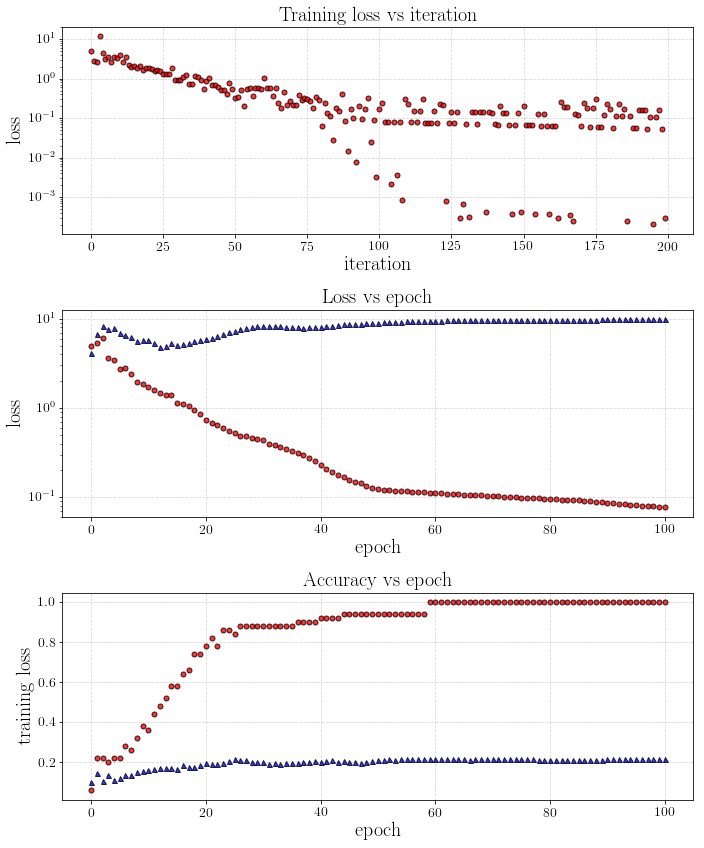

In [37]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [46]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2

kwargs = {'use_batchnorm': True, 'use_relu': True, 'dropout': 0.00,
          'weight_scale': None, 'debug': False, 'dtype': np.float64, 'seed': 1}

model = FullyConnectedNet([100, 100, 100, 100], **kwargs)
solver = Solver(model, small_data,
                print_every_epoch=10,
                verbose=True,
                num_epochs=200, batch_size=25,
                update_rule='rmsprop',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train();

num of epochs = 200
num of iterations = 400
iterations per epoch = 2
(Epoch 10/200) train acc: 0.2; val acc: 0.11, train loss: 2.1964; val loss: 2.3186
(Epoch 20/200) train acc: 0.24; val acc: 0.12, train loss: 2.0161; val loss: 2.348
(Epoch 30/200) train acc: 0.4; val acc: 0.15, train loss: 1.8592; val loss: 2.5239
(Epoch 40/200) train acc: 0.48; val acc: 0.18, train loss: 1.4893; val loss: 2.5717
(Epoch 50/200) train acc: 0.54; val acc: 0.18, train loss: 1.2338; val loss: 2.8381
(Epoch 60/200) train acc: 0.64; val acc: 0.16, train loss: 1.0479; val loss: 2.9811
(Epoch 70/200) train acc: 0.78; val acc: 0.17, train loss: 0.71048; val loss: 3.3236
(Epoch 80/200) train acc: 0.76; val acc: 0.15, train loss: 0.72228; val loss: 3.7603
(Epoch 90/200) train acc: 0.88; val acc: 0.17, train loss: 0.47526; val loss: 3.8675
(Epoch 100/200) train acc: 0.84; val acc: 0.16, train loss: 0.45698; val loss: 4.1839
(Epoch 110/200) train acc: 0.96; val acc: 0.18, train loss: 0.22698; val loss: 4.3589
(Ep

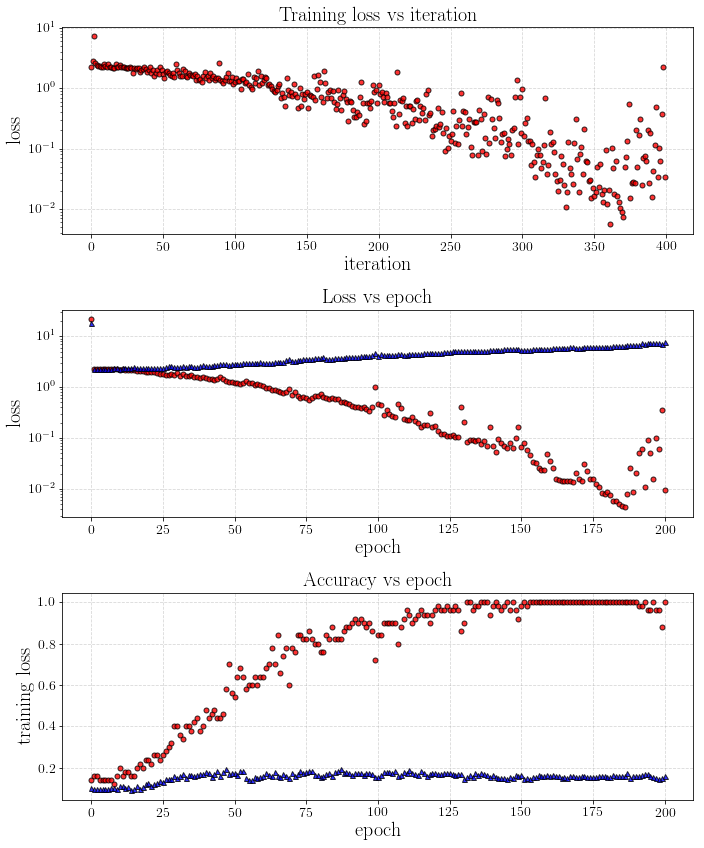

In [47]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

#### Answer:
[FILL THIS IN]

<a id='bn_mult'></a>
### 1.10.3 Batch Normalization  [[toc](#toc)]
Now that you have a working implementation for batch normalization, go back to your `FullyConnectedNet` in the file `cs2312n/classifiers/fc_net.py`. Modify your implementation to add batch normalization.

Concretely, when the flag `use_batchnorm` is `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

HINT: You might find it useful to define an additional helper layer similar to those in the file `cs231n/layer_utils.py`. If you decide to do so, do it in the file `cs231n/classifiers/fc_net.py`.

<a id='bn_test'></a>
#### 1.10.3.1 Test  [[toc](#toc)]

In [49]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))
reg = 1e-3

kwargs = {'use_batchnorm': True,
          'reg': reg,
          'input_dim': D,
          'num_classes': C,
          'weight_scale': None,
          'dtype': np.float64}

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], **kwargs)
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0:
        print()

Running check with reg =  0
Initial loss:  2.39442354117
W0 relative error: 8.90e-04
W1 relative error: 2.31e-01
W2 relative error: 5.00e-10
b0 relative error: 5.29e-15
b1 relative error: 3.47e-10
b2 relative error: 9.52e-11
beta0 relative error: 3.34e-01
beta1 relative error: 2.07e-09
gamma0 relative error: 3.35e-01
gamma1 relative error: 1.20e-08

Running check with reg =  3.14
Initial loss:  2.43235948923
W0 relative error: 5.45e-05
W1 relative error: 1.91e-01
W2 relative error: 5.34e-10
b0 relative error: 4.24e-14
b1 relative error: 3.47e-10
b2 relative error: 1.71e-10
beta0 relative error: 3.33e-01
beta1 relative error: 5.34e-09
gamma0 relative error: 3.33e-01
gamma1 relative error: 4.69e-09


<a id='bn_deep'></a>
#### 1.10.3.2 Batchnorm for deep networks  [[toc](#toc)]
Run the following to train a six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [50]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = None
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model    = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=100, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every_epoch=10)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=100, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every_epoch=10)
solver.train();

num of epochs = 100
num of iterations = 2000
iterations per epoch = 20
(Epoch 10/100) train acc: 0.21; val acc: 0.19, train loss: 2.0571; val loss: 2.1784
(Epoch 20/100) train acc: 0.32; val acc: 0.21, train loss: 1.8387; val loss: 2.1336
(Epoch 30/100) train acc: 0.39; val acc: 0.21, train loss: 1.6057; val loss: 2.3758
(Epoch 40/100) train acc: 0.48; val acc: 0.23, train loss: 1.3705; val loss: 2.429
(Epoch 50/100) train acc: 0.61; val acc: 0.26, train loss: 1.0359; val loss: 2.705
(Epoch 60/100) train acc: 0.72; val acc: 0.28, train loss: 0.73761; val loss: 3.0993
(Epoch 70/100) train acc: 0.8; val acc: 0.27, train loss: 0.51406; val loss: 3.4987
(Epoch 80/100) train acc: 0.88; val acc: 0.29, train loss: 0.36598; val loss: 3.7167
(Epoch 90/100) train acc: 0.95; val acc: 0.29, train loss: 0.20148; val loss: 3.7383
(Epoch 100/100) train acc: 0.96; val acc: 0.29, train loss: 0.14042; val loss: 4.2026
num of epochs = 100
num of iterations = 2000
iterations per epoch = 20
(Epoch 10/100) 

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

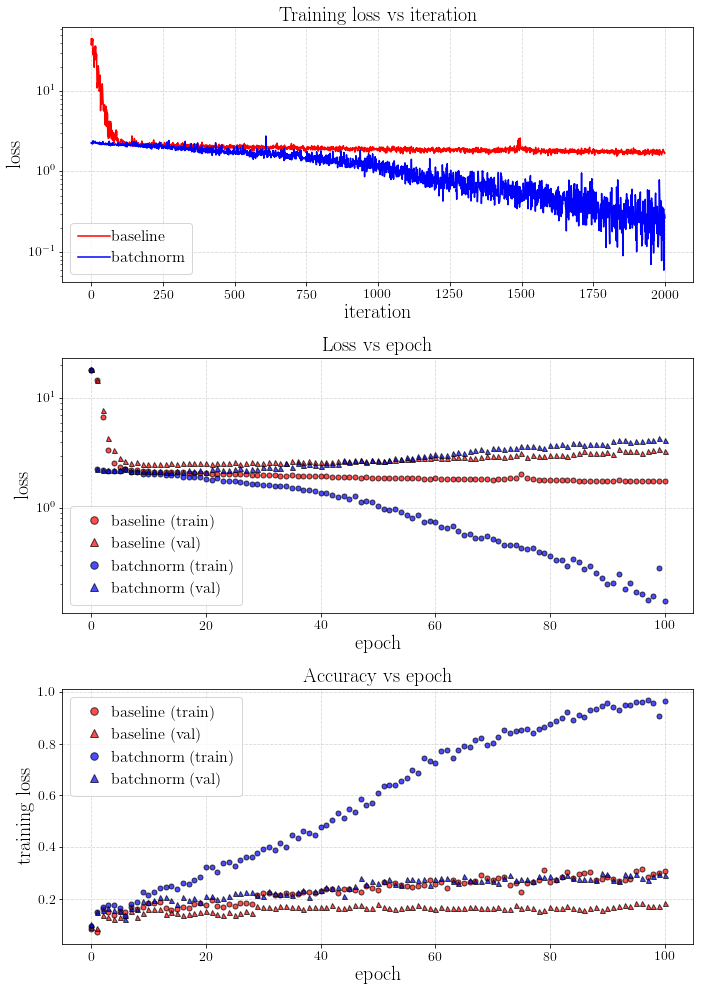

In [60]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}

ax = axarr[0]
ax.plot(solver.loss_history, color='r', label='baseline')
ax.plot(bn_solver.loss_history, color='b', label='batchnorm')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[1]
ax.plot(solver.train_loss_history,    'o', color='r', label='baseline (train)', **plot_kwargs)
ax.plot(solver.val_loss_history,      '^', color='r', label='baseline (val)', **plot_kwargs)
ax.plot(bn_solver.train_loss_history, 'o', color='b', label='batchnorm (train)', **plot_kwargs)
ax.plot(bn_solver.val_loss_history,   '^', color='b', label='batchnorm (val)', **plot_kwargs)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', label='baseline (train)', **plot_kwargs)
ax.plot(solver.val_acc_history,   '^', color='r', label='baseline (val)', **plot_kwargs)
ax.plot(bn_solver.train_acc_history, 'o', color='b', label='batchnorm (train)', **plot_kwargs)
ax.plot(bn_solver.val_acc_history,   '^', color='b', label='batchnorm (val)', **plot_kwargs)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=16)

plt.tight_layout()
plt.show()

<a id='bn_deep_init'></a>
#### 1.10.3.3 Batch normalization and initialization [[toc](#toc)]
We will now run a small experiment to study the interaction of batch normalization and weight initialization.

The first cell will train 8-layer networks both with and without batch normalization using different scales for weight initialization. The second layer will plot training accuracy, validation set accuracy, and training loss as a function of the weight initialization scale.

In [61]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'],
  'y_val':   data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=50, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=True, print_every_epoch=5)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=50, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=True, print_every_epoch=5)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


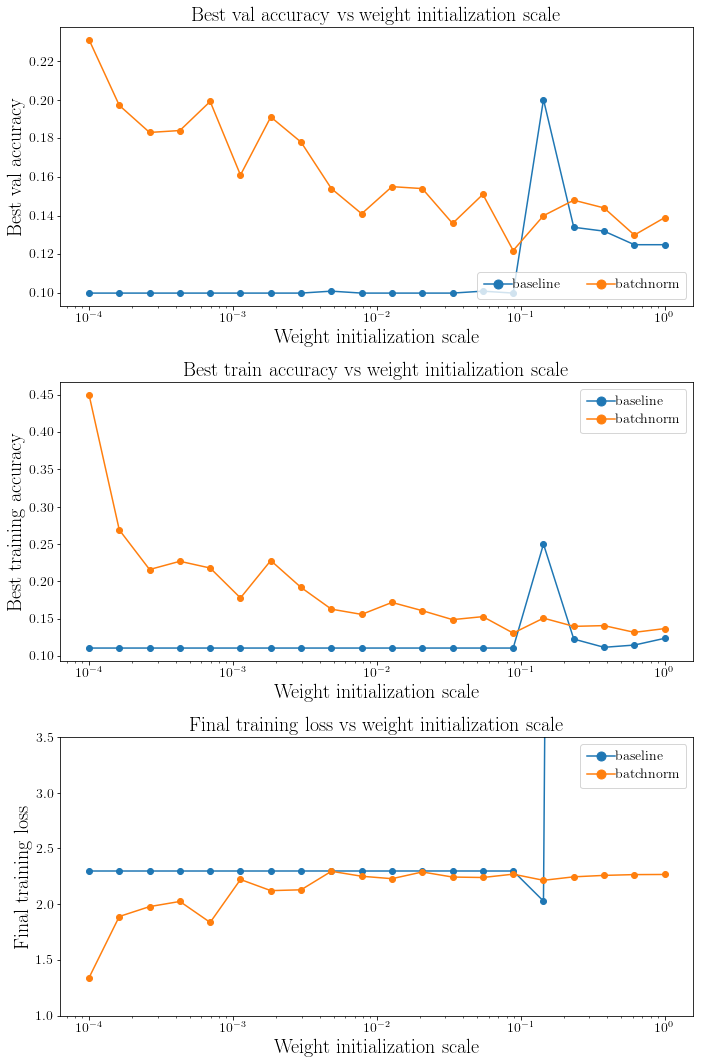

In [63]:
# Plot results of weight scale experiment
best_train_accs,  bn_best_train_accs  = [], []
best_val_accs,    bn_best_val_accs    = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(10, 15)
plt.tight_layout()
plt.show()

#### Question:
Describe the results of this experiment, and try to give a reason why the experiment gave the results that it did.
#### Answer:

<a id='fcn_dropout'></a>
### 1.10.4 Fully-connected nets with Dropout [[toc](#toc)]
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specificially, if the constructor the the net receives a nonzero value for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123, keep_seed=True) # keep_seed=True is critical here
    
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  0
Initial loss:  2.30372718575
W0 relative error: 5.57e-06
W1 relative error: 2.76e-06
W2 relative error: 1.33e-08
b0 relative error: 8.20e-08
b1 relative error: 8.93e-09
b2 relative error: 9.92e-11

Running check with dropout =  0.25
Initial loss:  2.30388335617
W0 relative error: 1.13e-06
W1 relative error: 1.27e-06
W2 relative error: 1.34e-07
b0 relative error: 6.30e-08
b1 relative error: 1.76e-08
b2 relative error: 1.49e-10

Running check with dropout =  0.5
Initial loss:  2.30304553052
W0 relative error: 6.49e-07
W1 relative error: 9.48e-07
W2 relative error: 8.71e-08
b0 relative error: 1.94e-07
b1 relative error: 2.67e-08
b2 relative error: 1.11e-10



<a id='reg_exp'></a>
#### 1.10.4.1 Regularization experiment [[toc](#toc)]
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [8]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print('dropout =', dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every_iter=5)
    solver.train()
    solvers[dropout] = solver

dropout = 0
num of epochs = 25
num of iterations = 125
iterations per epoch = 5
(Iteration 5/125) loss: 2.2152497471643757
(Iteration 10/125) loss: 2.2748180020744466
(Iteration 15/125) loss: 2.0951618454814502
(Iteration 20/125) loss: 2.1536452695681363
(Iteration 25/125) loss: 2.038810191980779
(Iteration 30/125) loss: 1.920610237148042
(Iteration 35/125) loss: 1.8054077274926805
(Iteration 40/125) loss: 1.8932469148730942
(Iteration 45/125) loss: 1.8234327857176411
(Iteration 50/125) loss: 1.7550238263356153
(Iteration 55/125) loss: 1.597910481745543
(Iteration 60/125) loss: 1.59641543863978
(Iteration 65/125) loss: 1.5404417587285753
(Iteration 70/125) loss: 1.3890836628765448
(Iteration 75/125) loss: 1.370749312791909
(Iteration 80/125) loss: 1.1396309405432539
(Iteration 85/125) loss: 1.1353098013815823
(Iteration 90/125) loss: 1.2120273964932669
(Iteration 95/125) loss: 1.1537663977511012
(Iteration 100/125) loss: 1.138930198977866
(Iteration 105/125) loss: 1.1997516633348995
(I

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

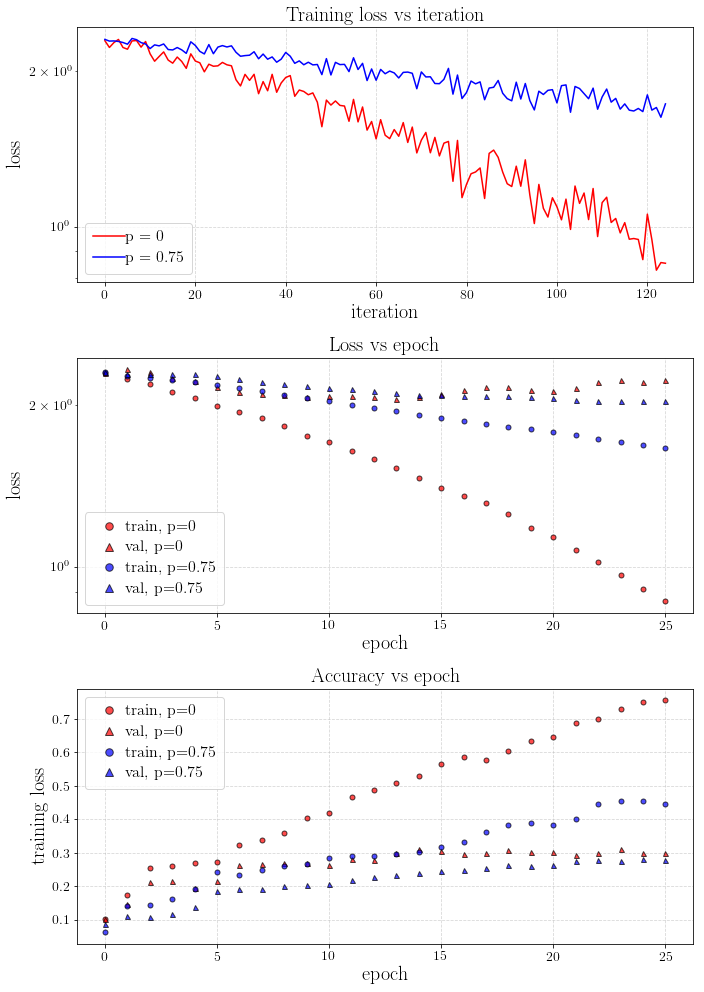

In [14]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
markers = {0: 'o', 0.75: '^'}
colors = {0: 'r', 0.75: 'b'}

for dropout in dropout_choices:
    solver = solvers[dropout]
    
    ax = axarr[0]
    ax.plot(solver.loss_history, color=colors[dropout], label='p = {}'.format(dropout))

    ax = axarr[1]
    ax.plot(solver.train_loss_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_loss_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout),   **plot_kwargs)

    ax = axarr[2]
    ax.plot(solver.train_acc_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_acc_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout), **plot_kwargs)

ax = axarr[0]   
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[1]
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)
    
ax = axarr[2]
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=16)
    
plt.tight_layout()
plt.show()

#### Question
Explain what you see in this experiment. What does it suggest about dropout?
#### Answer

<a id='final_model'></a>
### 1.10.5 Final model [[toc](#toc)]

<a id='fcn_good'></a>
#### 1.10.5.1 Train model [[toc](#toc)]
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

<a id='fcn_test'></a>
#### 1.10.5.2 Test model [[toc](#toc)]
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

<a id='cnn'></a>
# 2. Convolutional Networks  [[toc](#toc)]
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

<a id='cnn_conv'></a>
## 2.1 Convolution [[toc](#toc)]

<a id='cnn_conv_forw'></a>
### 2.1.1 Convolution: Naive forward pass  [[toc](#toc)]
The core of a convolutional network is the convolution operation. In the file `ml/neural_network/cs231n/second/conv_layers_naive.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


<a id='cnn_conv_aside'></a>
### 2.1.2 Aside: Image processing via convolutions [[toc](#toc)]
As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check. 

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


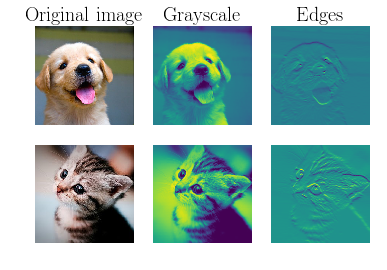

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

<a id='cnn_conv_back'></a>
### 2.1.3 Convolution: Naive backward pass [[toc](#toc)]
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [6]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.15980316116e-08
dw error:  2.24710943494e-10
db error:  3.37261539588e-11


<a id='cnn_max_pooling'></a>
## 2.2 Max pooling [[toc](#toc)]

<a id='cnn_max_pooling_forw'></a>
### 2.2.1 Max pooling: Naive forward  [[toc](#toc)]
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [7]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


<a id='cnn_max_pooling_back'></a>
### 2.2.2 Max pooling: Naive backward [[toc](#toc)]
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [8]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223e-12


<a id='cnn_fast'></a>
## 2.3 Fast layers [[toc](#toc)]
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [9]:
from time import time

np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.303102s
Fast: 0.013694s
Speedup: 22.133483x
Difference:  1.97056314066e-11

Testing conv_backward_fast:
Naive: 9.180176s
Fast: 0.012926s
Speedup: 710.204497x
dx difference:  2.0126604133e-11
dw difference:  2.57766409929e-13
db difference:  3.13938580256e-15


In [10]:
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 1.019685s
fast: 0.002434s
speedup: 418.972375x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.092232s
speedup: 8.984834x
dx difference:  0.0


<a id='cnn_sand'></a>
## 2.4 Convolutional "sandwich" layers [[toc](#toc)]
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [10]:
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  4.39750283427e-09
dw error:  3.65169939729e-09
db error:  7.05481262422e-10


In [12]:
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  8.03522627181e-09
dw error:  2.09024057453e-10
db error:  3.28795840264e-10


<a id='cnn_spatial'></a>
## 2.5 Spatial Batch Normalization [[toc](#toc)]
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

<a id='cnn_spatial_forw'></a>
### 2.5.1 Spatial batch normalization: forward [[toc](#toc)]

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [23]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.33463814  8.90909116  9.11056338]
  Stds:  [ 3.61447857  3.19347686  3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  6.27276009e-16   6.13398221e-16  -1.05471187e-16]
  Stds:  [ 0.99999723  0.99999687  0.99999716]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.9999917   3.99998747  4.99998578]


In [19]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034378  0.07562855  0.05716351  0.04378368]
  stds:  [ 0.96718413  1.02996788  1.02887272  1.00585232]


<a id='cnn_spatial_back'></a>
### 2.5.2 Spatial batch normalization: backward [[toc](#toc)]
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [26]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  3.51419372256e-06
dgamma error:  1.7957991295e-11
dbeta error:  3.27560872528e-12


<a id='cnn_three'></a>
## 2.6 Three-layer ConvNet  [[toc](#toc)]
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

In [3]:
from ml.neural_network.cs231n.second.padding import *

In [38]:
from builtins import object
import numpy as np

#from cs231n.layers import *
#from cs231n.fast_layers import *
#from cs231n.layer_utils import *

class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), 
                 n_filters=32, filter_size=7,           # convolution params
                 hidden_dim=100,                          # first affine layer
                 n_classes=10,                          # second affine layer
                 weight_scale=None, reg=0.0,
                 use_batchnorm=False,
                 random_state=0,
                 dtype=np.float64,
                 debug=False):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - n_filters: Number of filters to use in the convolutional layer
        - filter_size: Size of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - n_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - use_batchnorm: 
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        
    
        self.reg = reg
        self.dtype = dtype
        self.random_state = random_state
        self.gen = np.random.RandomState(random_state)
        self.use_batchnorm = use_batchnorm
        self.debug = debug
        # Shapes and dimensions
        
        n_channels, image_h, image_w = input_dim
        self.input_dim = input_dim
        self.n_channels = n_channels; self.image_h = image_h; self.image_w = image_w
        self.n_filters = n_filters
        self.n_classes = n_classes

        self.params = {}
        self.output_shapes = {}
        
        # Convolution layer parameters
        assert image_h == image_w, 'Image height and width must be equal. Otherwise padding problem can occur.'
        conv_stride = 1 # convolution uses stride = 1
        assert filter_size % 2 == 1, 'Filter size must be odd.'
        conv_pad = (filter_size - 1) // 2
        output_h = float(image_h + 2 * conv_pad - filter_size) / conv_stride + 1
        output_w = float(image_w + 2 * conv_pad - filter_size) / conv_stride + 1
        assert output_h == int(output_h), 'Conv layer: height padding is incorrect'
        assert output_w == int(output_w), 'Conv layer: width padding is incorrect'
        assert output_h == output_w, 'Output of the first conv layer must have equal height and width.'
        assert output_h == image_h, 'Output size of the conv layer must be equal to the input one.'
        output_h = int(output_h); output_w = int(output_w)
        self.output_shapes['conv'] = (-1, n_filters, output_h, output_w)
        # pass conv_param to the forward pass for the convolutional layer
        self.conv_param = {}
        self.conv_param['stride'] = conv_stride
        self.conv_param['filter_size'] = filter_size
        self.conv_param['pad'] = conv_pad
        # Convolution weights and biases
        if weight_scale is None:
            scale = 1.0 /  np.sqrt(n_channels * filter_size * filter_size)
        else:
            scale = weight_scale

        self.params['W1'] = self.gen.normal(size=(n_filters, n_channels, filter_size, filter_size), scale=scale)
        self.params['b1'] = np.zeros((n_filters))
        
        # Batchnorm
        if self.use_batchnorm:
            self.bn_param = {'momentum': 0.9, 'eps': 1e-8, 'mode': 'train'}
            self.params['gamma'] = np.ones(n_filters)
            self.params['beta'] = np.zeros(n_filters)
        
        # Pooling parameters
        # pass pool_param to the forward pass for the max-pooling layer
        self.pool_param = {}
        self.pool_param['pool_height'] = 2
        self.pool_param['pool_width']  = 2
        self.pool_param['stride']      = 2
        assert output_h % 2 == 0, 'Output height of the conv layer must be even.'
        assert output_w % 2 == 0, 'Output width of the conv layer must be even.'
        output_h //= 2
        output_w //= 2
        self.output_shapes['pool'] = (-1, n_filters, output_h, output_w)
        
        # First affine layer
        affine_input = int(n_filters * output_h * output_w)
        if weight_scale is None:
            scale = 1.0 / np.sqrt(affine_input)
        else:
            scale = weight_scale
        self.params['W2'] = self.gen.normal(size=(affine_input, hidden_dim), scale=scale)
        self.params['b2'] = np.zeros((hidden_dim,))
        self.output_shapes['affine1'] = (-1, hidden_dim)
        
        # Second affine layer
        if weight_scale is None:
            scale = 1.0 / np.sqrt(hidden_dim)
        else:
            scale = weight_scale
        self.params['W3'] = self.gen.normal(size=(hidden_dim, n_classes), scale=scale)
        self.params['b3'] = np.zeros((n_classes,))
        self.output_shapes['softmax'] = (-1, n_classes)

        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)
        
    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        n_samples, n_channels, image_h, image_w = X.shape
        assert (n_channels, image_h, image_w) == self.input_dim
        if self.use_batchnorm:
            mode = 'test' if y is None else 'train'
            self.bn_param['mode'] = mode
        
        outputs = {}; caches = {}
        
        if self.debug: print('FORWARD\nX1.shape', X.shape)
            
        if self.use_batchnorm:
            outputs['conv_bn_relu'], caches['conv_bn_relu'] = conv_bn_relu_forward(
                X, W1, b1, self.params['gamma'], self.params['beta'], self.conv_param, self.bn_param)
            outputs['pool'], caches['pool'] = max_pool_forward_fast(outputs['conv_bn_relu'], self.pool_param)
            X2 = outputs['pool']
        else:
            outputs['conv_relu_pool'], caches['conv_relu_pool'] = conv_relu_pool_forward(
                X, W1, b1, self.conv_param, self.pool_param)
            X2 = outputs['conv_relu_pool']
        X2_shape = X2.shape   
        if self.debug: print('X2.shape', X2.shape)
            
        assert X2.shape[1:] == self.output_shapes['pool'][1:]
        X2 = X2.reshape((n_samples, -1))
        if self.debug: print('X2 reshaped to {} for passing to affine layer with W.shape = {}'.format(
            X2.shape, W2.shape))
        
        
        outputs['affine_relu'], caches['affine_relu'] = affine_relu_forward(X2, W2, b2)
        X3 = outputs['affine_relu']
        if self.debug: print('X3.shape', X3.shape)
        
        outputs['affine'], caches['affine'] = affine_forward(X3, W3, b3)
        scores = outputs['affine']
        if self.debug: print('scores.shape', scores.shape)
        assert scores.shape == (n_samples, self.n_classes)
       
        if y is None:
            return scores

        self.grads = {}
        
        loss, scores_grad = softmax_loss(scores, y)
        if self.debug: print('\bBACKWARD\nscores_grad.shape {}, loss = {}'.format(scores_grad.shape, loss))
            
        X3_grad, W3_grad, b3_grad = affine_backward(scores_grad, caches['affine'])
        assert W3_grad.shape == W3.shape; assert b3_grad.shape == b3.shape
        loss += 0.5 * self.reg * np.sum(W3 ** 2)
        W3_grad += self.reg * W3
        self.grads['W3'] = W3_grad; self.grads['b3'] = b3_grad
        if self.debug: print('X3_grad.shape', X3_grad.shape)
        
        X2_grad, W2_grad, b2_grad = affine_relu_backward(X3_grad, caches['affine_relu'])
        assert W2_grad.shape == W2.shape; assert b2_grad.shape == b2.shape
        loss += 0.5 * self.reg * np.sum(W2 ** 2)
        W2_grad += self.reg * W2
        self.grads['W2'] = W2_grad; self.grads['b2'] = b2_grad
        if self.debug: print('X2_grad.shape', X2_grad.shape)
        X2_grad = X2_grad.reshape(X2_shape)
        if self.debug: print('X2_grad reshaped to', X2_grad.shape)
            
        if self.use_batchnorm:
            pool_grad = max_pool_backward_fast(X2_grad, caches['pool'])
            X1_grad, W1_grad, b1_grad, gamma_grad, beta_grad = conv_bn_relu_backward(pool_grad, caches['conv_bn_relu'])
            self.grads['gamma'] = gamma_grad
            self.grads['beta'] = beta_grad
        else:
            X1_grad, W1_grad, b1_grad = conv_relu_pool_backward(X2_grad, caches['conv_relu_pool'])
        assert W1_grad.shape == W1.shape; assert b1_grad.shape == b1.shape
        loss += 0.5 * self.reg * np.sum(W1 ** 2)
        W1_grad += self.reg * W1
        self.grads['W1'] = W1_grad; self.grads['b1'] = b1_grad
        if self.debug: 
            print('X1_grad.shape', X1_grad.shape)
            for param_name in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']:
                print(param_name, self.params[param_name].shape, self.grads[param_name].shape)
            
        return loss, self.grads

<a id='cnn_three_sanity'></a>
### 2.6.1 Sanity check loss [[toc](#toc)]
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [39]:
model = ThreeLayerConvNet(n_filters=32, use_batchnorm=True, debug=False)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.87713606659
Initial loss (with regularization):  38.295943352


<a id='cnn_three_grad'></a>
### 2.6.2 Gradient check [[toc](#toc)]
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [42]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(n_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64, debug=False, use_batchnorm=True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.221201e-08
W2 max relative error: 2.632249e-07
W3 max relative error: 2.969574e-09
b1 max relative error: 2.220447e-02
b2 max relative error: 3.167081e-10
b3 max relative error: 9.340024e-10
beta max relative error: 8.372573e-10
gamma max relative error: 1.236828e-09


<a id='cnn_three_overfit'></a>
### 2.6.3 Overfit small data [[toc](#toc)]
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [52]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2, use_batchnorm=True)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                    'learning_rate': 3e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=True, 
                print_every_epoch=1)
model = solver.train()

num of epochs = 15
num of iterations = 30
iterations per epoch = 2
(Epoch 1/15) train acc: 0.16; val acc: 0.1, train loss: 5.5604; val loss: 5.7849
(Epoch 2/15) train acc: 0.27; val acc: 0.18, train loss: 3.6821; val loss: 3.7411
(Epoch 3/15) train acc: 0.29; val acc: 0.21, train loss: 2.4713; val loss: 2.7868
(Epoch 4/15) train acc: 0.47; val acc: 0.21, train loss: 1.7436; val loss: 2.5318
(Epoch 5/15) train acc: 0.52; val acc: 0.19, train loss: 1.6601; val loss: 2.8796
(Epoch 6/15) train acc: 0.44; val acc: 0.16, train loss: 1.6; val loss: 3.0541
(Epoch 7/15) train acc: 0.54; val acc: 0.18, train loss: 1.281; val loss: 2.8431
(Epoch 8/15) train acc: 0.64; val acc: 0.21, train loss: 1.1779; val loss: 2.784
(Epoch 9/15) train acc: 0.73; val acc: 0.22, train loss: 0.99798; val loss: 2.6947
(Epoch 10/15) train acc: 0.76; val acc: 0.23, train loss: 0.84658; val loss: 2.6323
(Epoch 11/15) train acc: 0.72; val acc: 0.21, train loss: 0.81998; val loss: 2.9283
(Epoch 12/15) train acc: 0.8; va

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

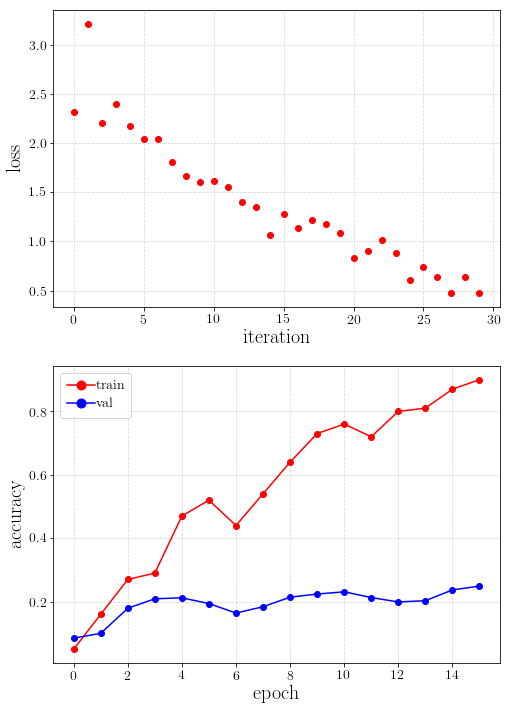

In [56]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o', color='r', zorder=2)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o', color='r', zorder=2)
plt.plot(solver.val_acc_history, '-o', color='b', zorder=2)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

<a id='cnn_three_train'></a>
### 2.6.4 Train net [[toc](#toc)]
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [58]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every_iter=20)
model = solver.train()

num of epochs = 1
num of iterations = 980
iterations per epoch = 980
(Iteration 20/980) loss: 2.0902864855252563
(Iteration 40/980) loss: 1.7849973358864888
(Iteration 60/980) loss: 1.74543153511561
(Iteration 80/980) loss: 1.7848495819525667
(Iteration 100/980) loss: 1.6882001100268815
(Iteration 120/980) loss: 1.7037821808992661
(Iteration 140/980) loss: 1.7265996247014312
(Iteration 160/980) loss: 1.679504104275444
(Iteration 180/980) loss: 1.6388035647742514
(Iteration 200/980) loss: 1.3928123169657927
(Iteration 220/980) loss: 1.6826061904533702
(Iteration 240/980) loss: 1.66854406432848
(Iteration 260/980) loss: 1.5866789100571315
(Iteration 280/980) loss: 1.4117076069995693
(Iteration 300/980) loss: 1.5779107624995818
(Iteration 320/980) loss: 1.483004330651699
(Iteration 340/980) loss: 1.4447497796863897
(Iteration 360/980) loss: 1.5401995033662386
(Iteration 380/980) loss: 1.5864428970983107
(Iteration 400/980) loss: 1.487066796490936
(Iteration 420/980) loss: 1.71684151590361

In [60]:
scores = model.loss(data['X_val'])
y_pred = np.argmax(scores, axis=1)
y_true = data['y_val']
print(np.mean(y_pred == y_true))

0.543


<a id='cnn_three_visualize'></a>
### 2.6.5 Visualize filters [[toc](#toc)]
You can visualize the first-layer convolutional filters from the trained network by running the following:

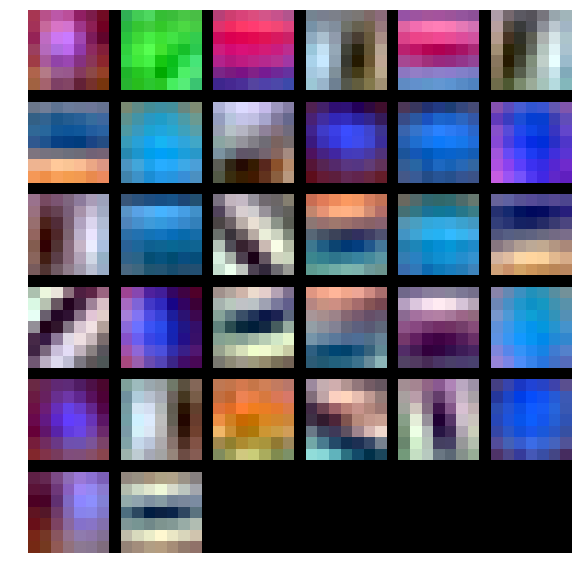

In [62]:
from ml.utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1), n_cols=6)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()

## Extra Credit Description [[toc](#toc)]
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

<a id='tf'></a>
# 3. TensorFlow [[toc](#toc)]

<a id='tf_intro'></a>
## 3.1 Introduction [[toc](#toc)]

### What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

### How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

<a id='tf_load'></a>
## 3.2 Load dataset [[toc](#toc)]

In [3]:
# Invoke the above function to get our data.
# Load the (preprocessed) CIFAR10 data.
gc.collect()
data = get_CIFAR10_data(image_data_format='channels_last',
                        ordered=False, substract_mean=True, ravel=False,
                        random_state=1, cifar10_dir=CIFAR10_DIR)
X_train = data['X_train'] / 255.0; y_train = data['y_train']
X_val   = data['X_val'] / 255.0;  y_val   = data['y_val']
X_test  = data['X_test'] / 255.0; y_test  = data['y_test']
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 32, 32, 3)
Training labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


<a id='tf_example'></a>
## 3.3 Example tensorflow model  [[toc](#toc)]

<a id='tf_some'></a>
### 3.3.1 Some useful utilities  [[toc](#toc)]

Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the width of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

<a id='tf_example'></a>
### 3.3.2  The example model itself  [[toc](#toc)]

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

<a id='tf_detail'></a>
### 3.3.3 TensorFlow Details   [[toc](#toc)]
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [4]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X, y):
    # define our weights (e.g. init_two_layer_convnet), setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])
    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 2, 2, 1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1, [-1, 5408])
    y_out = tf.matmul(h1_flat, W1) + b1
    return y_out

y_out = simple_model(X, y)
 
# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y, 10), logits=y_out)
mean_loss  = tf.reduce_mean(total_loss)

# define our optimizer
optimizer  = tf.train.AdamOptimizer(5e-4)   # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

<a id='tf_training'></a>
### 3.3.4 Training the model on one epoch [[toc](#toc)]
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 100: with minibatch training loss = 0.206 and accuracy of 0.23
Iteration 200: with minibatch training loss = 0.206 and accuracy of 0.23
Iteration 300: with minibatch training loss = 0.205 and accuracy of 0.33
Iteration 400: with minibatch training loss = 0.203 and accuracy of 0.41
Iteration 500: with minibatch training loss = 0.201 and accuracy of 0.5
Iteration 600: with minibatch training loss = 0.198 and accuracy of 0.58
Iteration 700: with minibatch training loss = 0.205 and accuracy of 0.44
Epoch 1, Overall loss = 0.21 and accuracy of 0.339


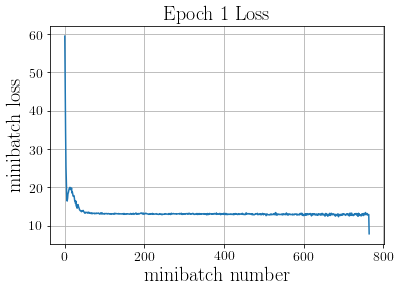

Validation
Epoch 1, Overall loss = 0.203 and accuracy of 0.431


In [6]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    """
    Inputs:
    
    Returns:
    """
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for start_idx in range(0, Xd.shape[0], batch_size):
            # generate indicies for the batch
            end_idx = min(start_idx + batch_size, Xd.shape[0])
            idx = train_indicies[start_idx:end_idx]
            # create a feed dictionary for this batch
            feed_dict = {X:           Xd[idx, :],
                         y:           yd[idx],
                         is_training: training_now}
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables, feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss * actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and ((iter_cnt + 1) % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt + 1, loss, np.sum(corr) / actual_batch_size))
            iter_cnt += 1
        total_correct = correct / Xd.shape[0]
        total_loss = np.sum(losses) / Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss, total_correct, e + 1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e + 1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss, total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess, y_out, mean_loss, X_train, y_train, 1, 64, 100, train_step, True)
        print('Validation')
        run_model(sess, y_out, mean_loss, X_val, y_val, 1, 64)

<a id='tf_specific'></a>
## 3.4 Training a specific model [[toc](#toc)]

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs

In [51]:
# Invoke the above function to get our data.
# Load the (preprocessed) CIFAR10 data.
gc.collect()
data = get_CIFAR10_data(image_data_format='channels_last',
                        ordered=False, substract_mean=True, ravel=False,
                        random_state=1, cifar10_dir=CIFAR10_DIR)
X_train = data['X_train'] / 255.0; y_train = data['y_train']
X_val   = data['X_val'] / 255.0;  y_val   = data['y_val']
X_test  = data['X_test'] /255.0; y_test  = data['y_test']
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 32, 32, 3)
Training labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [38]:
class Convolution2D:
    def __init__(self, input, filter_shape, padding='VALID', activation='relu', seed=None):
        """
        Inputs:
        - input_shape: [H, W, C]
        - output_shape: [CC, HH, WW]
        """
        self.input = input
        self.seed = seed
        self.input_shape = self.input.get_shape()
        self.filter_shape = filter_shape
        self.strides = [1, 1, 1, 1]
        self.padding = padding
        self.activation = activation
        self.seed = seed
        
        n_samples, height, widht, n_channels = self.input.get_shape()
        n_channels = n_channels.value
        n_filters, filter_h, filter_w = self.filter_shape
        W_shape = [filter_h, filter_w, n_channels, n_filters]
        stddev = 1.0 / (filter_h * filter_w * n_channels)
        W_init = tf.truncated_normal(W_shape, stddev=stddev, seed=seed, dtype=tf.float32)
        self.W = tf.Variable(W_init, name='W_conv')
        self.b = tf.Variable(tf.zeros([n_filters]), name='b_conv')
        self.params = [self.W, self.b]

    def get_output(self):
        self.output = tf.nn.conv2d(self.input, self.W, self.strides, self.padding) + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(self.output)
        return self.output
    

class MaxPooling:
    def __init__(self, input,  ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'):
        self.input = input
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
        
    def get_output(self):
        self.output = tf.nn.max_pool(self.input, ksize=self.ksize, strides=self.strides, padding=self.padding)
        return self.output
    
    
class Flatten:
    def __init__(self, input):
        self.input = input
    def get_output(self):
        n_samples, input_h, input_w, n_channels = self.input.get_shape()
        n_samples, input_h, input_w, n_channels = n_samples.value, input_h.value, input_w.value, n_channels.value 
        self.output = tf.reshape(self.input, [-1, input_h * input_w * n_channels])
        return self.output
    
    
class FullyConnected:
    def __init__(self, input, hidden_size, activation='relu', seed=None):
        self.input = input
        self.activation = activation
        n_samples, n_in = input.get_shape()
        n_in = n_in.value
        W_init = tf.truncated_normal([n_in, hidden_size], stddev=1.0 / n_in, dtype=tf.float32, seed=seed)
        self.W = tf.Variable(W_init, name='W_fc')
        self.b = tf.Variable(tf.zeros([hidden_size]), name='b_fc')
    
    def get_output(self):
        self.output = tf.matmul(self.input, self.W) + self.b
        if self.activation == 'relu':
            self.output = tf.nn.relu(self.output)
        return self.output

In [40]:
def loss(y_pred, y_true):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)
    loss = tf.reduce_mean(cross_entropy)
    return loss

def accuracy(y_pred, y_true):
    correct = tf.equal(tf.argmax(y_pred, 1), y_true, name='correct')
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
    return accuracy

def training(loss, learning_rate):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False) # Create a variable to track the global step.
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op


def inference(X, y_, conv_filter_shapes=[(32, 7, 7)], hidden_sizes=[1024], num_classes=10, learning_rate=1e-4, seed=0):
    """
    Inputs:
        
    Returns: 
        
    """
    from collections import OrderedDict
    outputs = OrderedDict()
    layers = OrderedDict()
    params = OrderedDict()
    for n_conv, filter_shape in enumerate(conv_filter_shapes):
        with tf.variable_scope('conv_{}'.format(n_conv)):
            layer_name = 'conv{}'.format(n_conv)
            output_name = layer_name + '_out'
            layers[layer_name] = layer = Convolution2D(X, filter_shape=filter_shape, activation='relu', seed=seed)
            out = outputs[output_name] = layer.get_output()
            params[layer_name + '_W'] = layer.W
            params[layer_name + '_b'] = layer.b
            seed += 1

    with tf.variable_scope('mp_1'):
        layer_name = 'mp1'
        output_name = layer_name + '_out'
        layers[layer_name] = layer = MaxPooling(out)
        out = outputs[output_name] = layer.get_output()

    with tf.variable_scope('flatten_1'):
        layer_name = 'flatten1'
        output_name = layer_name + '_out'
        layers[layer_name] = layer = Flatten(out)
        out = outputs[output_name] = layer.get_output()
            
    for n_affine, hidden_size in enumerate(hidden_sizes):   
        with tf.variable_scope('fc_{}'.format(n_affine)):
            layer_name = 'fc{}'.format(n_affine)
            output_name = layer_name + '_out'
            layers[layer_name] = layer = FullyConnected(out, hidden_size, activation='relu', seed=seed)
            out = outputs[output_name] = layer.get_output()
            params[layer_name + '_W'] = layer.W
            params[layer_name + '_b'] = layer.b
            seed += 1
    
    with tf.variable_scope('fc_last'):
        layer_name = 'fc_last'
        output_name = layer_name + 'out'
        layers[layer_name] = layer = FullyConnected(out, num_classes, activation='none', seed=seed)
        out = outputs[output_name] = layer.get_output()
        params[layer_name + '_W'] = layer.W
        params[layer_name + '_b'] = layer.b
        seed += 1

    y_pred = tf.nn.softmax(out)
    outputs['softmax'] = y_pred
    loss_value = loss(out, y_)
    accuracy_value = accuracy(y_pred, y_)
    train_step = training(loss_value, learning_rate)
    model = {'probas': y_pred, 'loss': loss_value, 'accuracy': accuracy_value, 'train_step': train_step,
             'layers': layers, 'outputs': outputs, 'params': params}
    return model

#### Training

In [45]:
class TfTrainer:
    def __init__(self, model_creator, model_kwargs=None):
        self.model_creator = model_creator
        self.model_kwargs = model_kwargs

    def train(self, data, n_epochs=10, batch_size=128, seed=0,
              verbose=False, print_every_iter=None, print_every_epoch=None):
        """
        - data:
          - X_train: [N, H, W, C], np.array
          - y_train: [N], np.array
          - X_val:
          - y_val:
        """
        # Creating datasets
        if verbose: print('Creating datasets.')
        X_train = data['X_train']
        y_train = data['y_train']
        X_val = data['X_val']
        y_val = data['y_val']
        assert X_train.shape[1:] == X_val.shape[1:]
        image_h, image_w, n_channels = X_train.shape[1:]

        tf.reset_default_graph()
        X_train_ph = tf.placeholder(dtype=tf.float32, shape=[None, image_h, image_w, n_channels], name='X_train')
        y_train_ph = tf.placeholder(dtype=tf.int64, shape=[None], name='y_train')
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_ph, y_train_ph))
        train_dataset = train_dataset.repeat().shuffle(1000, seed=seed).batch(batch_size)
        seed += 1

        X_val_ph = tf.placeholder(dtype=tf.float32, shape=[None, image_h, image_w, n_channels], name='X_val')
        y_val_ph = tf.placeholder(dtype=tf.int64, shape=[None], name='y_val')
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val_ph, y_val_ph))
        val_dataset = val_dataset.batch(batch_size)

        handle = tf.placeholder(tf.string, shape=[])
        iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)
        next_element = iterator.get_next()

        train_iterator = train_dataset.make_initializable_iterator()
        val_iterator  = val_dataset.make_initializable_iterator()

        # model
        if verbose: print('Creating model.')
        X = tf.placeholder(dtype=tf.float32, shape=[None, image_h, image_w, n_channels])
        y_ = tf.placeholder(dtype=tf.int64, shape=[None])
        if self.model_kwargs is None: self.model_kwargs = {}
        self.model_kwargs['seed'] = seed              # Attention!
        #self.model_kwargs['print_shapes'] = verbose   # Attention!
        
        self.model = self.model_creator(X, y_, **self.model_kwargs)
        layers = self.model['layers']
        outputs = self.model['outputs']
        params = self.model['params']
        if verbose:
            print('Shapes:')
            for k, v in outputs.items():
                print('\t', k, v.get_shape())
            print('Params:')
            for k in params:
                print('\t', k)
        loss_value     = self.model['loss']
        accuracy_value = self.model['accuracy']
        train_step     = self.model['train_step']

        # history
        if verbose: print('Creating history.')
        self.train_acc_vs_iter  = []
        self.train_acc_vs_epoch = []
        self.train_loss_vs_iter = []
        self.train_loss_vs_epoch = []
        self.val_acc_vs_epoch  = []
        self.val_loss_vs_epoch = []
        self.history = {
            'train_acc_vs_iter': self.train_acc_vs_iter,
            'train_loss_vs_iter': self.train_loss_vs_iter,
            'train_acc_vs_epoch': self.train_acc_vs_epoch,
            'train_loss_vs_epoch': self.train_loss_vs_epoch,
            'val_acc_vs_epoch': self.val_acc_vs_epoch,
            'val_loss_vs_epoch': self.val_loss_vs_epoch
        }
        
        # verbose
        if print_every_iter is None: print_every_iter = 1000000000000
        if print_every_epoch is None: print_every_epoch = 1000000000000
        n_iter = 0

        # Training
        n_samples_per_epoch = X_train.shape[0]
        if verbose: print('Samples per epoch = {}'.format(n_samples_per_epoch))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(train_iterator.initializer, feed_dict={X_train_ph: X_train, y_train_ph: y_train})
            train_handle = sess.run(train_iterator.string_handle())

            for n_epoch in range(n_epochs):
                #print(sess.run(params['conv0_b']))
                train_acc = 0
                train_loss = 0
                n_train_samples = 0
                while True:
                    X_batch, y_batch = sess.run(next_element, feed_dict={handle: train_handle})
                    loss_, acc_, _ = sess.run([loss_value, accuracy_value, train_step], 
                                               feed_dict={X: X_batch, y_: y_batch})
                    self.train_acc_vs_iter.append(acc_)
                    self.train_loss_vs_iter.append(loss_)
                    train_acc += acc_ * X_batch.shape[0]
                    train_loss += loss_ * X_batch.shape[0]
                    n_train_samples += X_batch.shape[0]
                    n_iter += 1
                    if n_iter % print_every_iter == 0:
                        print('\ttrain iter {}: accuracy={:.2f}, loss={:.4f}'.format(
                                n_iter, acc_, loss_))
                    if n_train_samples >= n_samples_per_epoch:
                        break
                self.train_acc_vs_epoch.append(train_acc / n_train_samples)
                self.train_loss_vs_epoch.append(train_loss / n_train_samples)

                sess.run(val_iterator.initializer, feed_dict={X_val_ph: X_val, y_val_ph: y_val})
                val_handle = sess.run(val_iterator.string_handle())
                val_acc = 0
                val_loss = 0
                n_val_samples = 0
                while True:
                    try:
                        X_batch, y_batch = sess.run(next_element, feed_dict={handle: val_handle})
                        loss_, acc_ = sess.run([loss_value, accuracy_value], feed_dict={X: X_batch, y_: y_batch})
                        val_acc  += acc_  * X_batch.shape[0]
                        val_loss += loss_ * X_batch.shape[0]
                        n_val_samples += X_batch.shape[0]
                    except tf.errors.OutOfRangeError as e:
                        break
                self.val_acc_vs_epoch.append(val_acc / n_val_samples)
                self.val_loss_vs_epoch.append(val_loss / n_val_samples)

                if (n_epoch + 1) % print_every_epoch == 0:
                    print('n_epoch = {}/{}, train accuracy = {:.2f}, train loss = {:.4}'.format(
                        n_epoch + 1, n_epochs, self.train_acc_vs_epoch[-1], self.train_loss_vs_epoch[-1]))
                    print('n_epoch = {}/{}, val accuracy   = {:.2f}, val loss   = {:.4}'.format(
                        n_epoch + 1, n_epochs, self.val_acc_vs_epoch[-1], self.val_loss_vs_epoch[-1]))
        return self.model, self.history

In [47]:
# clear old variables
tf.reset_default_graph()
model_kwargs = {'num_classes': 10,
                'learning_rate': 1e-3}
tf_trainer = TfTrainer(inference, model_kwargs)
model, history = tf_trainer.train(data, batch_size=200, 
                                  n_epochs=10,
                                  verbose=False, 
                                  print_every_iter=None, 
                                  print_every_epoch=1)

n_epoch = 1/10, train accuracy = 0.43, train loss = 1.612
n_epoch = 1/10, val accuracy   = 0.51, val loss   = 1.407
n_epoch = 2/10, train accuracy = 0.55, train loss = 1.286
n_epoch = 2/10, val accuracy   = 0.57, val loss   = 1.239
n_epoch = 3/10, train accuracy = 0.60, train loss = 1.145
n_epoch = 3/10, val accuracy   = 0.59, val loss   = 1.244
n_epoch = 4/10, train accuracy = 0.63, train loss = 1.057
n_epoch = 4/10, val accuracy   = 0.60, val loss   = 1.14
n_epoch = 5/10, train accuracy = 0.66, train loss = 0.9928
n_epoch = 5/10, val accuracy   = 0.62, val loss   = 1.175
n_epoch = 6/10, train accuracy = 0.67, train loss = 0.956
n_epoch = 6/10, val accuracy   = 0.64, val loss   = 1.123
n_epoch = 7/10, train accuracy = 0.68, train loss = 0.9259
n_epoch = 7/10, val accuracy   = 0.62, val loss   = 1.155
n_epoch = 8/10, train accuracy = 0.70, train loss = 0.8824
n_epoch = 8/10, val accuracy   = 0.64, val loss   = 1.116
n_epoch = 9/10, train accuracy = 0.71, train loss = 0.8463
n_epoch = 9

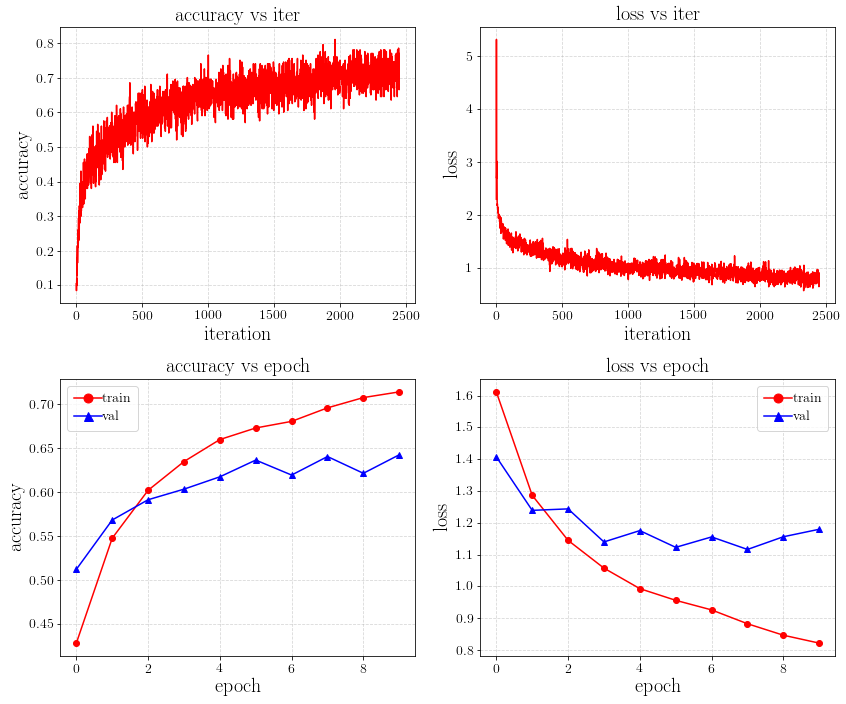

In [48]:
f, axarr = plt.subplots(2, 2, figsize=(12, 10), sharex=False)

ax = axarr[0, 0]
ax.plot(np.array(history['train_acc_vs_iter']), color='r', zorder=2)
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel('iteration'); ax.set_ylabel('accuracy'); ax.set_title('accuracy vs iter');

ax = axarr[0, 1]
ax.plot(np.array(history['train_loss_vs_iter']), color='r', zorder=2)
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel('iteration'); ax.set_ylabel('loss'); ax.set_title('loss vs iter');

ax = axarr[1, 0]
ax.plot(history['train_acc_vs_epoch'], marker='o', color='r', label='train', zorder=2)
ax.plot(history['val_acc_vs_epoch'], marker='^', color='b', label='val', zorder=2)
ax.grid(linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); ax.set_title('accuracy vs epoch');

ax = axarr[1, 1]
ax.plot(history['train_loss_vs_epoch'], marker='o', color='r', label='train', zorder=2)
ax.plot(history['val_loss_vs_epoch'], marker='^', color='b', label='val', zorder=2)
ax.grid(linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlabel('epoch'); ax.set_ylabel('loss'); ax.set_title('loss vs epoch');
plt.tight_layout()

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [ ]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out, feed_dict={X: x, is_training:True})
        %timeit sess.run(y_out, feed_dict={X: x, is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

You should see the following from the run above 

`(64, 10)`

`True`

<a id='tf_gpu'></a>
### GPU! [[toc]](#toc)

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [ ]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X, y, is_training)

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [ ]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = None
optimizer = None
pass

In [ ]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [ ]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

<a id='tf_cifar10_great'></a>
## 3.5 Train a _great_ model on CIFAR-10! [[toc]](#toc)
Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

<a id='tf_model1'></a>
### Model 1 [[toc]](#toc)

In [90]:
def cnn_model_fn(features, labels, mode):
    layers = OrderedDict()
    layers['input'] = tf.reshape(features['X'], [-1, 32, 32, 3])

    out = layers['conv1'] = tf.layers.conv2d(layers['input'], filters=32, kernel_size=[4, 4], 
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu, name='conv1')
    out = layers['pool1'] = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=[2, 2], name='pool1')
    
    out = layers['conv2'] = tf.layers.conv2d(out, filters=64, kernel_size=[4, 4], 
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu, name='conv2')
    out = layers['pool2'] = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=[2, 2], name='pool2')
    
    #input_size = tf.reduce_prod(tf.prod out.get_shape()[1:])
    out = layers['flatten'] = tf.layers.flatten(out, name='flatten')
    out = layers['dense1'] = tf.layers.dense(out, 1024, kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu)
    
    out = layers['dropout1'] = tf.layers.dropout(out, rate=0.5, seed=11, 
                                                 training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    logits = layers['logits'] = tf.layers.dense(out, units=10)
    
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [91]:
# Create the Estimator
tf.reset_default_graph()
cifar_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="tmp/cifar_model")
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_master': '', '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_tf_random_seed': None, '_model_dir': 'tmp/cifar_model', '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7b4001bb70>, '_save_summary_steps': 100, '_task_id': 0, '_num_ps_replicas': 0, '_session_config': None, '_save_checkpoints_steps': None}


In [92]:
# Train the model
batch_size = 200
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"X": X_train.astype(np.float32)}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)
cifar_classifier.train(input_fn=train_input_fn, steps=500) #, hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tmp/cifar_model/model.ckpt-5500
INFO:tensorflow:Saving checkpoints for 5501 into tmp/cifar_model/model.ckpt.
INFO:tensorflow:step = 5501, loss = 0.176445
INFO:tensorflow:global_step/sec: 20.898
INFO:tensorflow:step = 5601, loss = 0.136048 (4.786 sec)
INFO:tensorflow:global_step/sec: 21.1544
INFO:tensorflow:step = 5701, loss = 0.157512 (4.728 sec)
INFO:tensorflow:global_step/sec: 21.3704
INFO:tensorflow:step = 5801, loss = 0.136001 (4.679 sec)
INFO:tensorflow:global_step/sec: 21.3773
INFO:tensorflow:step = 5901, loss = 0.0604918 (4.678 sec)
INFO:tensorflow:Saving checkpoints for 6000 into tmp/cifar_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.14405.


In [93]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': X_val.astype(np.float32)}, y=y_val, 
                                                   batch_size=batch_size, shuffle=False)
eval_metrics = cifar_classifier.evaluate(input_fn=eval_input_fn)
print(eval_metrics)

INFO:tensorflow:Starting evaluation at 2018-01-15-08:58:25
INFO:tensorflow:Restoring parameters from tmp/cifar_model/model.ckpt-6000
INFO:tensorflow:Finished evaluation at 2018-01-15-08:58:26
INFO:tensorflow:Saving dict for global step 6000: accuracy = 0.754, global_step = 6000, loss = 1.0108
{'accuracy': 0.75400001, 'loss': 1.0108035, 'global_step': 6000}


<a id='tf_model1'></a>
### Model 2 [[toc]](#toc)

In [153]:
def cnn_model2_fn(features, labels, mode, params):
    layers = OrderedDict()
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    out = layers['input'] = tf.reshape(features['X'], [-1, 32, 32, 3])
    
    # bn->conv->relu->pool
    #out = layers['bn1']   = tf.layers.batch_normalization(out, training=training)
    out = layers['conv1'] = tf.layers.conv2d(out, filters=32, kernel_size=[3, 3], 
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu, name='conv1')
    out = layers['pool1'] = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=[2, 2], name='pool1')
    
    # bn->conv->relu->pool
    out = layers['bn2']   = tf.layers.batch_normalization(out, training=training)
    out = layers['conv2'] = tf.layers.conv2d(out, filters=64, kernel_size=[3, 3],
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu, name='conv2')
    out = layers['pool2'] = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=[2, 2], name='pool2')
    
    # bn->conv->relu->pool
    #out = layers['bn3']   = tf.layers.batch_normalization(out, training=training)
    out = layers['conv3'] = tf.layers.conv2d(out, filters=128, kernel_size=[3, 3],
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5),
                                             activation=tf.nn.relu, name='conv3')
    out = layers['pool3'] = tf.layers.max_pooling2d(out, pool_size=[2, 2], strides=[2, 2], name='pool3')
    
    out = layers['flatten'] = tf.layers.flatten(out, name='flatten')
    
    out = layers['dense1'] = tf.layers.dense(out, params['dense_size1'], activation=tf.nn.relu,
                                             kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5))
    out = layers['dropout1'] = tf.layers.dropout(out, rate=0.2, seed=11, training=training)
    
    out = layers['dense2'] = tf.layers.dense(out, params['dense_size2'], activation=tf.nn.relu,
                                            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-5))
    out = layers['dropout2'] = tf.layers.dropout(out, rate=0.2, seed=12, training=training)
    
    logits = layers['logits'] = tf.layers.dense(out, units=10)
    
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(params['learning_rate'])
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

        #train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [154]:
# Create the Estimator
tf.reset_default_graph()
params = {'learning_rate': 1e-3,
          'dense_size1': 512, 
          'dense_size2': 256}
cifar_classifier = tf.estimator.Estimator(model_fn=cnn_model2_fn, model_dir="tmp/cifar_model2", params=params)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_master': '', '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_tf_random_seed': None, '_model_dir': 'tmp/cifar_model2', '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7afc1136a0>, '_save_summary_steps': 100, '_task_id': 0, '_num_ps_replicas': 0, '_session_config': None, '_save_checkpoints_steps': None}


In [149]:
# Train the model
batch_size = 200
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"X": X_train.astype(np.float32)}, y=y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)
cifar_classifier.train(input_fn=train_input_fn, steps=5000) #, hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp/cifar_model2/model.ckpt.
INFO:tensorflow:step = 1, loss = 2.34819
INFO:tensorflow:global_step/sec: 18.7237
INFO:tensorflow:step = 101, loss = 1.45226 (5.342 sec)
INFO:tensorflow:global_step/sec: 18.5809
INFO:tensorflow:step = 201, loss = 1.13979 (5.386 sec)
INFO:tensorflow:global_step/sec: 18.2112
INFO:tensorflow:step = 301, loss = 1.11844 (5.488 sec)
INFO:tensorflow:global_step/sec: 19.1803
INFO:tensorflow:step = 401, loss = 1.07332 (5.213 sec)
INFO:tensorflow:global_step/sec: 19.2253
INFO:tensorflow:step = 501, loss = 1.03364 (5.203 sec)
INFO:tensorflow:global_step/sec: 19.0621
INFO:tensorflow:step = 601, loss = 0.854466 (5.245 sec)
INFO:tensorflow:global_step/sec: 19.1489
INFO:tensorflow:step = 701, loss = 0.91514 (5.222 sec)
INFO:tensorflow:global_step/sec: 19.0923
INFO:tensorflow:step = 801, loss = 1.00232 (5.238 sec)
INFO:tensorflow:global_step/sec: 19.1586
INFO:tensorflow:step = 901, lo

In [151]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': X_val.astype(np.float32)}, y=y_val, 
                                                   batch_size=batch_size, shuffle=False)
eval_metrics = cifar_classifier.evaluate(input_fn=eval_input_fn)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={'X': X_train.astype(np.float32)}, y=y_train, 
                                                   batch_size=batch_size, shuffle=False)
eval_metrics = cifar_classifier.evaluate(input_fn=eval_input_fn)
print(eval_metrics)

INFO:tensorflow:Starting evaluation at 2018-01-15-11:41:32
INFO:tensorflow:Restoring parameters from tmp/cifar_model2/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-01-15-11:41:33
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.703, global_step = 5000, loss = 1.34391
INFO:tensorflow:Starting evaluation at 2018-01-15-11:41:33
INFO:tensorflow:Restoring parameters from tmp/cifar_model2/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-01-15-11:41:38
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.946939, global_step = 5000, loss = 0.154266
{'accuracy': 0.94693875, 'loss': 0.1542661, 'global_step': 5000}


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

<a id='tf_extra'></a>
## Extra credit description [[toc]](#toc)
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

<a id='tf_constants'></a>
### Constants [[toc]](#toc)

In [ ]:
tf.reset_default_graph()

In [81]:
sess = tf.Session()
a = tf.constant([1, 2, 3, 4], dtype=tf.float32, shape=(10, ), name='ConstArray')
print(a)
sess.run(a)

Tensor("ConstArray:0", shape=(10,), dtype=float32)


array([ 1.,  2.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.], dtype=float32)

In [83]:
node1 = tf.constant(3.0)
node2 = tf.constant(4.0)
print(node1, node2)
print(sess.run([node1, node2]))

Tensor("Const_2:0", shape=(), dtype=float32) Tensor("Const_3:0", shape=(), dtype=float32)
[3.0, 4.0]


In [85]:
node3 = tf.add(node1, node2, name='result')
print(node3)
print(sess.run(node3))

Tensor("result:0", shape=(), dtype=float32)
7.0


### Placeholders [[toc]](#toc)

In [7]:
tf.reset_default_graph()
a = tf.placeholder(tf.float32, name='V1')
b = tf.placeholder(tf.float32, name='V2')
s = a + b
print(a, b, s)
sess = tf.Session()
print(sess.run([a, b, s], feed_dict={a: [1, 2], b: [3, 4]}))
print(sess.run([a, b, s], feed_dict={a: 1, b: 2}))

Tensor("V1:0", dtype=float32) Tensor("V2:0", dtype=float32) Tensor("add:0", dtype=float32)
[array([ 1.,  2.], dtype=float32), array([ 3.,  4.], dtype=float32), array([ 4.,  6.], dtype=float32)]
[array(1.0, dtype=float32), array(2.0, dtype=float32), 3.0]


### Variables  [[toc]](#toc)

In [14]:
tf.reset_default_graph()
W = tf.Variable([.3], dtype=tf.float32, name='W')
b = tf.Variable([-.3], dtype=tf.float32, name='b')
x = tf.placeholder(dtype=tf.float32, name='X')
linear_model = W * x + b # W * x + b
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print(sess.run(linear_model, feed_dict={x: [1, 2, 3, 4]}))

[ 0.          0.30000001  0.60000002  0.90000004]


In [18]:
y = tf.placeholder(dtype=tf.float32, name='y_true')
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, feed_dict={x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

23.66


In [20]:
fixW = tf.assign(W, [-1.0])
fixb = tf.assign(b, [1.0])
sess.run([fixW, fixb])
print(sess.run(loss, feed_dict={x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


### Training [[toc]](#toc)

In [22]:
optimizer = tf.train.GradientDescentOptimizer(1e-2)
train = optimizer.minimize(loss)
sess.run(init)
for i in range(1000):
    sess.run(train, feed_dict={x: [1, 2, 3, 4], y: [0, -1, -2, -3]})
print(sess.run([W, b]))

[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]


### Estimator [[toc]](#toc)

In [26]:
tf.reset_default_graph()
sess = tf.Session()

feature_columns = [tf.feature_column.numeric_column('x', shape=[1])]
estimator = tf.estimator.LinearRegressor(feature_columns)
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])

print()

input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=500, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

print('\nTRAINING:')
estimator.train(input_fn=input_fn, steps=1000)
print('\nEVALUATING:')
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print("train metrics: %r"% train_metrics)
print("eval metrics: %r"% eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_num_ps_replicas': 0, '_session_config': None, '_model_dir': '/tmp/tmpqgg9cwv6', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f88d019ccf8>, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_task_id': 0, '_tf_random_seed': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}


TRAINING:
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpqgg9cwv6/model.ckpt.
INFO:tensorflow:step = 1, loss = 26.0
INFO:tensorflow:global_step/sec: 585.663
INFO:tensorflow:step = 101, loss = 0.465157 (0.172 sec)
INFO:tensorflow:global_step/sec: 723.736
INFO:tensorflow:step = 201, loss = 0.0882952 (0.139 sec)
INFO:tensorflow:global_step/sec: 708.131
INFO:tensorflow:

In [31]:
tf.reset_default_graph()

W = tf.Variable([0.3], dtype=tf.float32)
b = tf.Variable([-0.3], dtype=tf.float32)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def model_fn(features, labels, mode):
    W = tf.get_variable('W', [1], dtype=tf.float64)
    b = tf.get_variable('b', [1], dtype=tf.float64)
    y = W * features['x'] + b
    loss = tf.reduce_sum(tf.square(y - labels))
    
    global_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss), tf.assign_add(global_step, 1))
    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=y,
                                      loss=loss,
                                      train_op=train)

estimator = tf.estimator.Estimator(model_fn=model_fn)

x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7., 0.])
input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

print('\nTRAINING:')
estimator.train(input_fn=input_fn, steps=1000)
print('\nEVALUATING:')
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print('train_metrics', train_metrics)
print('eval metrics', eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_num_ps_replicas': 0, '_session_config': None, '_model_dir': '/tmp/tmpc1rftin9', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f88d1983390>, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_task_id': 0, '_tf_random_seed': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}

TRAINING:
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpc1rftin9/model.ckpt.
INFO:tensorflow:step = 1, loss = 159.956639198
INFO:tensorflow:global_step/sec: 639.897
INFO:tensorflow:step = 101, loss = 0.241340587964 (0.158 sec)
INFO:tensorflow:global_step/sec: 900.991
INFO:tensorflow:step = 201, loss = 0.010780233793 (0.111 sec)
INFO:tensorflow:global_step/sec: 457.9

## MNIST [[toc]](#toc)

### Dense network [[toc]](#toc)

In [5]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
tf.reset_default_graph()
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_init = tf.truncated_normal([784, 10], stddev=0.1, seed=10)
W = tf.Variable(W_init)
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())

y = tf.matmul(x, W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [7]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9196


### Convolutional network

In [ ]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [39]:
def weight_variable(shape):
    W = tf.truncated_normal(shape, stddev=1.0)
    return tf.Variable(W)

def bias_variable(shape):
    bias = tf.zeros(shape)
    return tf.Variable(bias)

In [40]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [43]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# First convolution
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 28, 28, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second convolution
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Dense layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Dense layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [44]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.12
step 100, training accuracy 0.34
step 200, training accuracy 0.58
step 300, training accuracy 0.66
step 400, training accuracy 0.78
step 500, training accuracy 0.72
step 600, training accuracy 0.84
step 700, training accuracy 0.84
step 800, training accuracy 0.88
step 900, training accuracy 0.84
step 1000, training accuracy 0.94
step 1100, training accuracy 0.8
step 1200, training accuracy 0.88
step 1300, training accuracy 0.92
step 1400, training accuracy 0.88
step 1500, training accuracy 0.86
step 1600, training accuracy 0.88
step 1700, training accuracy 0.96
step 1800, training accuracy 0.9
step 1900, training accuracy 0.96
step 2000, training accuracy 0.9
step 2100, training accuracy 0.9
step 2200, training accuracy 0.86
step 2300, training accuracy 0.88
step 2400, training accuracy 0.9
step 2500, training accuracy 0.96
step 2600, training accuracy 0.96
step 2700, training accuracy 0.94
step 2800, training accuracy 0.96
step 2900, training accuracy 0.

<tf.Tensor 'Rank_3:0' shape=() dtype=int32>

In [3]:
tf.reset_default_graph()
A = tf.Variable([[1, 2], [3, 4]], dtype=tf.int32)
A_rank = tf.rank(A)
with tf.Session() as sess:
    print(A_rank.eval())

2


In [9]:
print(tf.GraphKeys.GLOBAL_VARIABLES)
print(tf.GraphKeys.TRAINABLE_VARIABLES)

variables
trainable_variables


In [10]:
my_local = tf.get_variable('my_local', shape=(), collections=[tf.GraphKeys.LOCAL_VARIABLES])

In [11]:
my_non_trainable = tf.get_variable('my_non_trainable', shape=(), trainable=False)